In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [38]:
fees= pd.read_csv('/kaggle/input/bank-customers/extract - fees - data analyst - .csv')
cash_request= pd.read_csv('/kaggle/input/bank-customers/extract - cash request - data analyst.csv')

In [39]:
cash_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [40]:
cr= cash_request.copy()
cr=cr[['amount','created_at', 'user_id', 'deleted_account_id', 'transfer_type']]
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [41]:
cr.fillna({'user_id':cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         23970 non-null  float64
 1   created_at     23970 non-null  object 
 2   user_id        23970 non-null  float64
 3   transfer_type  23970 non-null  object 
dtypes: float64(2), object(2)
memory usage: 749.2+ KB


In [42]:
cr['created_at']=pd.to_datetime(cr['created_at'])
cr.head()

amount                       created_at  user_id transfer_type
0   100.0 2019-12-10 19:05:21.596873+00:00    804.0       regular
1   100.0 2019-12-10 19:50:12.347780+00:00    231.0       regular
2   100.0 2019-12-10 19:13:35.825460+00:00    191.0       regular
3    99.0 2019-12-10 19:16:10.880172+00:00    761.0       regular
4   100.0 2020-05-06 09:59:38.877376+00:00   7686.0       regular

In [43]:
cr['created_at']=cr['created_at'].dt.tz_localize(None)
cr.head()

amount                 created_at  user_id transfer_type
0   100.0 2019-12-10 19:05:21.596873    804.0       regular
1   100.0 2019-12-10 19:50:12.347780    231.0       regular
2   100.0 2019-12-10 19:13:35.825460    191.0       regular
3    99.0 2019-12-10 19:16:10.880172    761.0       regular
4   100.0 2020-05-06 09:59:38.877376   7686.0       regular

In [44]:
cr['Month']=cr['created_at'].dt.to_period('M')
cr.head()

amount                 created_at  user_id transfer_type    Month
0   100.0 2019-12-10 19:05:21.596873    804.0       regular  2019-12
1   100.0 2019-12-10 19:50:12.347780    231.0       regular  2019-12
2   100.0 2019-12-10 19:13:35.825460    191.0       regular  2019-12
3    99.0 2019-12-10 19:16:10.880172    761.0       regular  2019-12
4   100.0 2020-05-06 09:59:38.877376   7686.0       regular  2020-05

In [45]:
cr['Cohort']=cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head()

amount                 created_at  user_id transfer_type    Month   Cohort
0   100.0 2019-12-10 19:05:21.596873    804.0       regular  2019-12  2019-12
1   100.0 2019-12-10 19:50:12.347780    231.0       regular  2019-12  2019-12
2   100.0 2019-12-10 19:13:35.825460    191.0       regular  2019-12  2019-12
3    99.0 2019-12-10 19:16:10.880172    761.0       regular  2019-12  2019-12
4   100.0 2020-05-06 09:59:38.877376   7686.0       regular  2020-05  2020-05

In [46]:
# calculate the number of the unique customers in each cohort
cohort_initial_sizes= cr.groupby('Cohort').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()
cohort_initial_sizes

Cohort  Number_of_initial_customers
0   2019-11                            1
1   2019-12                          254
2   2020-01                          106
3   2020-02                           90
4   2020-03                           86
5   2020-04                          246
6   2020-05                          432
7   2020-06                         1540
8   2020-07                         1482
9   2020-08                          728
10  2020-09                         1950
11  2020-10                         4802
12  2020-11                           76

In [47]:
cohort_monthly_sizes= cr.groupby(['Cohort','Month']).agg(Number_of_customers=('user_id', 'nunique')).reset_index()
cohort_monthly_sizes

Cohort    Month  Number_of_customers
0   2019-11  2019-11                    1
1   2019-11  2019-12                    1
2   2019-11  2020-04                    1
3   2019-11  2020-05                    1
4   2019-11  2020-08                    1
..      ...      ...                  ...
78  2020-09  2020-10                  680
79  2020-09  2020-11                   20
80  2020-10  2020-10                 4802
81  2020-10  2020-11                   15
82  2020-11  2020-11                   76

[83 rows x 3 columns]

In [48]:
cohort_cash_monthly= cr.groupby(['Cohort','Month']).agg(Num_requests=('user_id', 'count')).reset_index()
cohort_cash_monthly

Cohort    Month  Num_requests
0   2019-11  2019-11             1
1   2019-11  2019-12             1
2   2019-11  2020-04             1
3   2019-11  2020-05             1
4   2019-11  2020-08             1
..      ...      ...           ...
78  2020-09  2020-10           727
79  2020-09  2020-11            20
80  2020-10  2020-10          5043
81  2020-10  2020-11            15
82  2020-11  2020-11            76

[83 rows x 3 columns]

In [49]:
# calculate customer retention rate (unique customers per cohort in each month/initial customers in the cohort)
customers_retention= cohort_monthly_sizes.pivot(index='Cohort' , columns='Month' , values='Number_of_customers')
customers_retention= customers_retention.div(cohort_initial_sizes.set_index('Cohort')['Number_of_initial_customers'], axis=0)

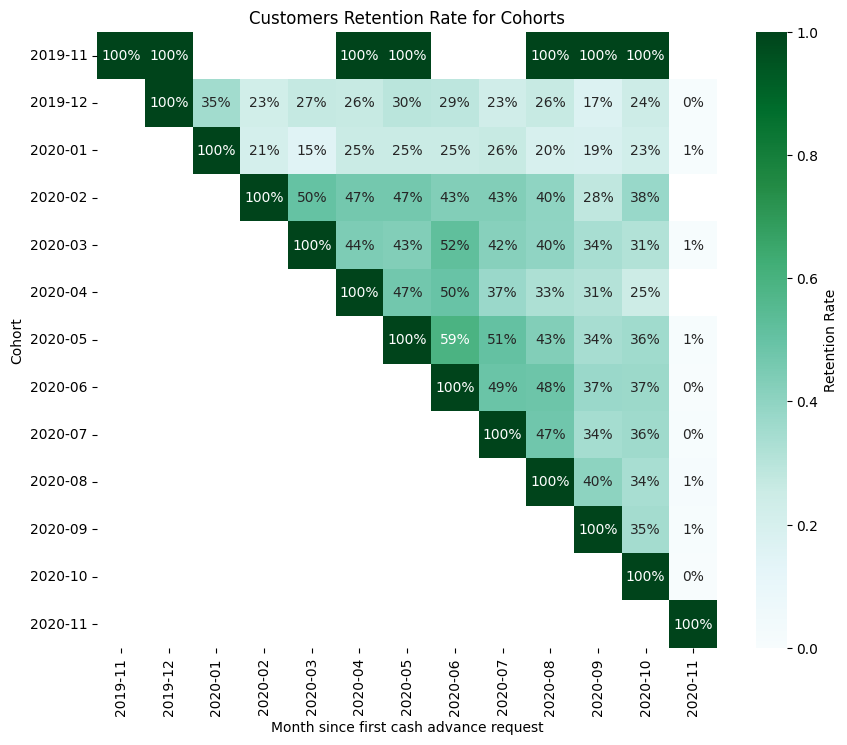

In [50]:
# Show the retention rate with heat map 
plt.figure(figsize=(10, 8))
plt.title('Customers Retention Rate for Cohorts')
sns.heatmap(data=customers_retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cmap='BuGn',
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

Text(95.72222222222221, 0.5, 'Cohort')

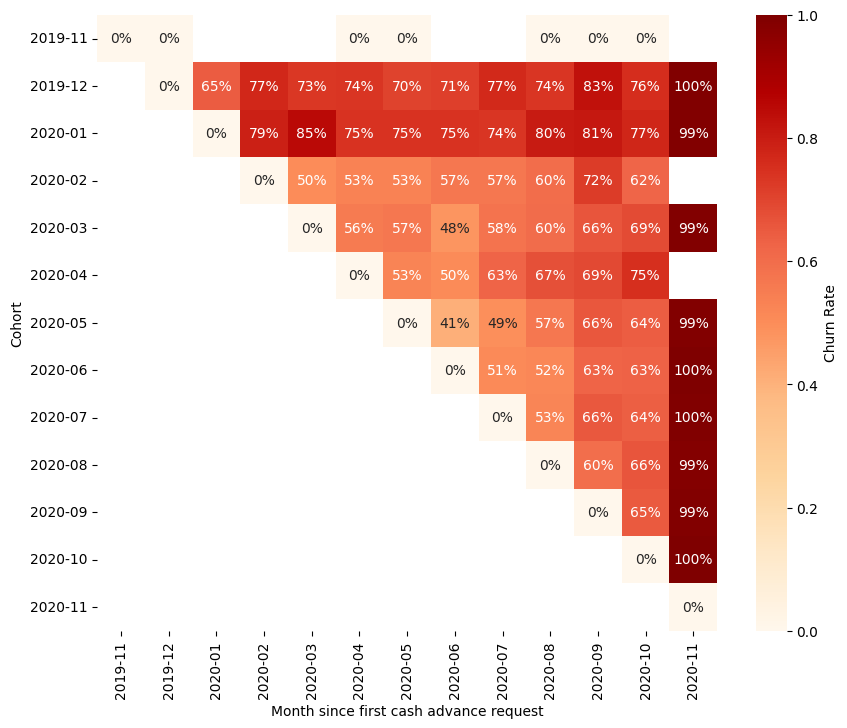

In [51]:
# calculate Churn Rate 
# Churn_rate= 1- retention_rate
churn_rate= 1- customers_retention

# plot the Churn rate 
plt.figure(figsize=(10, 8))
sns.heatmap(data=churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0 ,
            vmax=1.0,
            cmap='OrRd',
            cbar_kws={'label':'Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')

In [52]:
# calculate the initial number of cash advance requests in each cohort
cohort_cash_initial= cohort_cash_monthly.groupby('Cohort').first().reset_index().rename(columns={'Num_requests':'Num_initial_requests'})
cohort_cash_initial

Cohort    Month  Num_initial_requests
0   2019-11  2019-11                     1
1   2019-12  2019-12                   288
2   2020-01  2020-01                   117
3   2020-02  2020-02                    97
4   2020-03  2020-03                    99
5   2020-04  2020-04                   264
6   2020-05  2020-05                   478
7   2020-06  2020-06                  1934
8   2020-07  2020-07                  1996
9   2020-08  2020-08                   993
10  2020-09  2020-09                  2178
11  2020-10  2020-10                  5043
12  2020-11  2020-11                    76

In [53]:
# Request Retention Rate (for Cohorts in Each Month/ Number of Initial Request of Cohort)
retention_request= cohort_cash_monthly.pivot(index='Cohort', columns='Month', values='Num_requests')
retention_request= retention_request.div(cohort_cash_initial.set_index('Cohort')['Num_initial_requests'], axis=0)
retention_request

Month    2019-11  2019-12   2020-01   2020-02   2020-03   2020-04   2020-05  \
Cohort                                                                        
2019-11      1.0      1.0       NaN       NaN       NaN  1.000000  1.000000   
2019-12      NaN      1.0  0.368056  0.218750  0.274306  0.284722  0.298611   
2020-01      NaN      NaN  1.000000  0.205128  0.145299  0.299145  0.264957   
2020-02      NaN      NaN       NaN  1.000000  0.505155  0.505155  0.463918   
2020-03      NaN      NaN       NaN       NaN  1.000000  0.424242  0.464646   
2020-04      NaN      NaN       NaN       NaN       NaN  1.000000  0.568182   
2020-05      NaN      NaN       NaN       NaN       NaN       NaN  1.000000   
2020-06      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-07      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-08      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-09      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-10      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
2020-11      NaN      NaN       NaN       NaN       NaN       NaN       NaN   

Month     2020-06   2020-07   2020-08   2020-09   2020-10   2020-11  
Cohort                                                               
2019-11       NaN       NaN  1.000000  1.000000  2.000000       NaN  
2019-12  0.315972  0.250000  0.291667  0.184028  0.260417  0.003472  
2020-01  0.247863  0.264957  0.188034  0.188034  0.213675  0.008547  
2020-02  0.463918  0.463918  0.453608  0.278351  0.412371       NaN  
2020-03  0.474747  0.404040  0.363636  0.303030  0.303030  0.010101  
2020-04  0.571970  0.439394  0.405303  0.337121  0.284091       NaN  
2020-05  0.665272  0.573222  0.485356  0.376569  0.364017  0.008368  
2020-06  1.000000  0.531024  0.494829  0.355222  0.339193  0.002585  
2020-07       NaN  1.000000  0.471443  0.304609  0.298096  0.003507  
2020-08       NaN       NaN  1.000000  0.348439  0.284995  0.010070  
2020-09       NaN       NaN       NaN  1.000000  0.333792  0.009183  
2020-10       NaN       NaN       NaN       NaN  1.000000  0.002974  
2020-11       NaN       NaN       NaN       NaN       NaN  1.000000

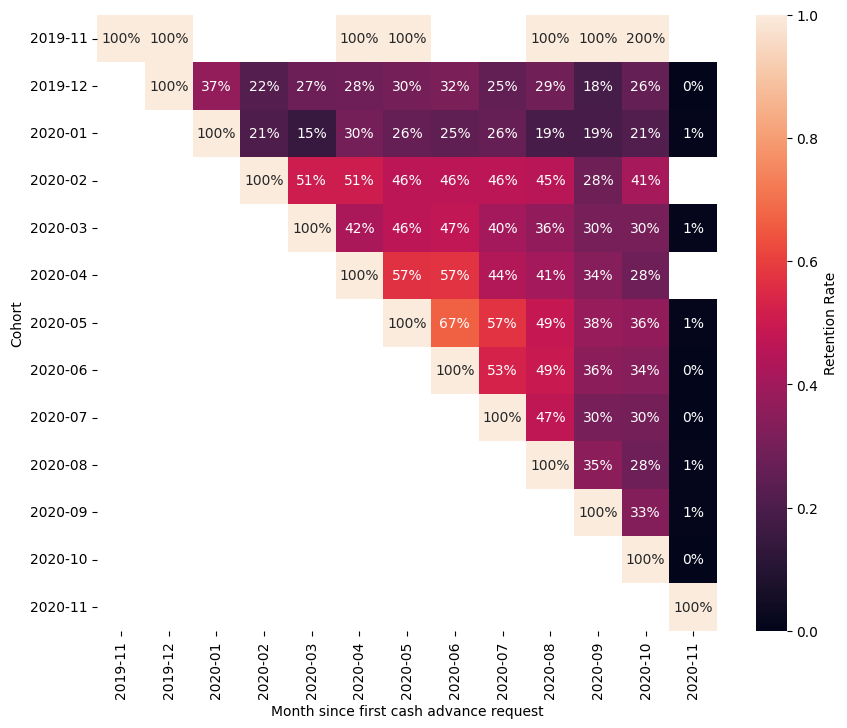

In [54]:
plt.figure(figsize=(10,8))
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(data=retention_request,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

In [55]:
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
def evaluate_regression_models(df, feature_col, target_col, poly_degrees=[1, 2, 3, 4, 5], 
                              alpha_values=[0.001, 0.01, 0.1, 1, 1.1, 1.5, 2], 
                              n_splits=5, random_state=42, test_size=0.2, extrapolation_size=0.2, l1_ratio=0.5):
    """
    Evaluate Ridge, Lasso, ElasticNet, and Linear Regression models with polynomial features.
    Includes 95% confidence intervals in the plots.

    Parameters:
    - df: pandas DataFrame, the dataset containing the feature and target columns.
    - feature_col: str, the name of the feature column.
    - target_col: str, the name of the target column.
    - poly_degrees: list, polynomial degrees to test.
    - alpha_values: list, regularization strengths for Ridge, Lasso, and ElasticNet.
    - n_splits: int, number of folds for cross-validation.
    - random_state: int, random seed for reproducibility.
    - test_size: float, proportion of the dataset to include in the test split.
    - extrapolation_size: float, proportion of the dataset to include in the extrapolation split.
    - l1_ratio: float, the mixing parameter for ElasticNet (0 <= l1_ratio <= 1).

    Returns:
    - Best predictive model (plots and prints evaluation metrics).
    """
    
    # Remove NaN values
    df_train = df.dropna()

    # Convert to numpy arrays
    X = np.array(df_train[feature_col]).reshape(-1, 1)
    y = np.array(df_train[target_col])

    # Split dataset into interpolation and extrapolation sets
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=extrapolation_size, 
                                                              random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=test_size, 
                                                        shuffle=True, random_state=random_state)

    # K-Fold Cross Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    best_model = None 
    # Loop through each polynomial degree
    for degree in poly_degrees:
        best_ridge_alpha, best_lasso_alpha, best_elastic_alpha = None, None, None
        best_ridge_model, best_lasso_model, best_elastic_model, best_linear_model = None, None, None, None
        best_ridge_mse, best_lasso_mse, best_elastic_mse, best_linear_mse = float('inf'), float('inf'), float('inf'), float('inf')
        best_r2score = float('inf')

        # Loop through different alpha values for Ridge, Lasso, and ElasticNet
        for alpha in alpha_values:
            # Ridge Regression
            ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
            ridge_preds = cross_val_predict(ridge_model, X_train, y_train, cv=kf)
            ridge_mse = mean_squared_error(y_train, ridge_preds)

            if ridge_mse < best_ridge_mse:
                best_ridge_mse = ridge_mse
                best_ridge_alpha = alpha
                best_ridge_model = ridge_model

            # Lasso Regression
            lasso_model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=10000))
            lasso_preds = cross_val_predict(lasso_model, X_train, y_train, cv=kf)
            lasso_mse = mean_squared_error(y_train, lasso_preds)

            if lasso_mse < best_lasso_mse:
                best_lasso_mse = lasso_mse
                best_lasso_alpha = alpha
                best_lasso_model = lasso_model

            # ElasticNet Regression
            elastic_model = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000))
            elastic_preds = cross_val_predict(elastic_model, X_train, y_train, cv=kf)
            elastic_mse = mean_squared_error(y_train, elastic_preds)

            if elastic_mse < best_elastic_mse:
                best_elastic_mse = elastic_mse
                best_elastic_alpha = alpha
                best_elastic_model = elastic_model

        # Linear Regression (No Regularization)
        linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        linear_preds = cross_val_predict(linear_model, X_train, y_train, cv=kf)
        best_linear_mse = mean_squared_error(y_train, linear_preds)
        best_linear_model = linear_model

        # Train the best models for this degree
        best_ridge_model.fit(X_interp, y_interp)
        best_lasso_model.fit(X_interp, y_interp)
        best_elastic_model.fit(X_interp, y_interp)
        best_linear_model.fit(X_interp, y_interp)
        # Predictions
        ridge_y_predict_interp = best_ridge_model.predict(X_interp)
        ridge_y_predict_extrap = best_ridge_model.predict(X_extrap)
        lasso_y_predict_interp = best_lasso_model.predict(X_interp)
        lasso_y_predict_extrap = best_lasso_model.predict(X_extrap)
        elastic_y_predict_interp = best_elastic_model.predict(X_interp)
        elastic_y_predict_extrap = best_elastic_model.predict(X_extrap)
        linear_y_predict_interp = best_linear_model.predict(X_interp)
        linear_y_predict_extrap = best_linear_model.predict(X_extrap)
        
        ridge_y_predict_train = best_ridge_model.predict(X_train)
        ridge_y_predict_test = best_ridge_model.predict(X_test)
        lasso_y_predict_train = best_lasso_model.predict(X_train)
        lasso_y_predict_test = best_lasso_model.predict(X_test)
        elastic_y_predict_train = best_elastic_model.predict(X_train)
        elastic_y_predict_test = best_elastic_model.predict(X_test)
        linear_y_predict_train = best_linear_model.predict(X_train)
        linear_y_predict_test = best_linear_model.predict(X_test)

        # Compute residuals for confidence intervals
        ridge_residuals = y_interp - ridge_y_predict_interp
        lasso_residuals = y_interp - lasso_y_predict_interp
        elastic_residuals = y_interp - elastic_y_predict_interp
        linear_residuals = y_interp - linear_y_predict_interp

        # Standard deviation of residuals
        ridge_std = np.std(ridge_residuals)
        lasso_std = np.std(lasso_residuals)
        elastic_std = np.std(elastic_residuals)
        linear_std = np.std(linear_residuals)

        # 95% confidence interval (1.96 * std)
        ridge_ci = 1.96 * ridge_std
        lasso_ci = 1.96 * lasso_std
        elastic_ci = 1.96 * elastic_std
        linear_ci = 1.96 * linear_std

        # Compute R² Scores for Extrapolation
        R2_ridge_gap_train = r2_score(y_train, ridge_y_predict_train)
        R2_ridge_gap_test = r2_score(y_test, ridge_y_predict_test)
        R2_ridge_gap = R2_ridge_gap_train - R2_ridge_gap_test
        if R2_ridge_gap < best_r2score:
            best_model = best_ridge_model
            best_r2score = R2_ridge_gap

        
        R2_lasso_gap_train = r2_score(y_train, lasso_y_predict_train)
        R2_lasso_gap_test = r2_score(y_test, lasso_y_predict_test)
        R2_lasso_gap = R2_lasso_gap_train - R2_lasso_gap_test
        if R2_lasso_gap <  best_r2score:
            best_model = best_lasso_model
            best_r2score = R2_lasso_gap

        
        R2_elastic_gap_train = r2_score(y_train, elastic_y_predict_train)
        R2_elastic_gap_test = r2_score(y_test, elastic_y_predict_test)
        R2_elastic_gap= R2_elastic_gap_train - R2_elastic_gap_test
        if R2_elastic_gap < best_r2score:
            best_model = best_elastic_model
            best_r2score = R2_elastic_gap
            
        
        R2_linear_gap_train = r2_score(y_train, linear_y_predict_train)
        R2_linear_gap_test = r2_score(y_test, linear_y_predict_test)
        R2_linear_gap = R2_linear_gap_train - R2_linear_gap_test
        if R2_linear_gap < best_r2score:
            best_model = best_linear_model
            best_r2score = R2_linear_gap

        
        # Plot Results
        plt.figure(figsize=(24, 5))

        # Ridge Plot
        plt.subplot(1, 4, 1)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, ridge_y_predict_interp, label='Ridge (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.flatten(), ridge_y_predict_interp - ridge_ci, ridge_y_predict_interp + ridge_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, ridge_y_predict_extrap, label='Ridge (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.flatten(), ridge_y_predict_extrap - ridge_ci, ridge_y_predict_extrap + ridge_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'Ridge (Degree {degree}, α={best_ridge_alpha})')
        plt.legend()

        # Lasso Plot
        plt.subplot(1, 4, 2)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, lasso_y_predict_interp, label='Lasso (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.flatten(), lasso_y_predict_interp - lasso_ci, lasso_y_predict_interp + lasso_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, lasso_y_predict_extrap, label='Lasso (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.flatten(), lasso_y_predict_extrap - lasso_ci, lasso_y_predict_extrap + lasso_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'Lasso (Degree {degree}, α={best_lasso_alpha})')
        plt.legend()

        # ElasticNet Plot
        plt.subplot(1, 4, 3)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, elastic_y_predict_interp, label='ElasticNet (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.flatten(), elastic_y_predict_interp - elastic_ci, elastic_y_predict_interp + elastic_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, elastic_y_predict_extrap, label='ElasticNet (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.flatten(), elastic_y_predict_extrap - elastic_ci, elastic_y_predict_extrap + elastic_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'ElasticNet (Degree {degree}, α={best_elastic_alpha})')
        plt.legend()

        # Linear Regression Plot
        plt.subplot(1, 4, 4)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, linear_y_predict_interp, label='Linear (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.flatten(), linear_y_predict_interp - linear_ci, linear_y_predict_interp + linear_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, linear_y_predict_extrap, label='Linear (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.flatten(), linear_y_predict_extrap - linear_ci, linear_y_predict_extrap + linear_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'Linear Regression (Degree {degree})')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Degree {degree}:")
        print(f"  Ridge (α={best_ridge_alpha}, MSE={best_ridge_mse:.4f}), ΔR² train & test={R2_ridge_gap:.4f}")
        print(f"  Lasso (α={best_lasso_alpha}, MSE={best_lasso_mse:.4f}), ΔR² train & test={R2_lasso_gap:.4f}")
        print(f"  ElasticNet (α={best_elastic_alpha}, MSE={best_elastic_mse:.4f}), ΔR² train & test={R2_elastic_gap:.4f}")
        print(f"  Linear Regression (MSE={best_linear_mse:.4f}), ΔR² train & test={R2_linear_gap:.4f}")
        print()  
    return best_model

In [57]:
def evaluate_polynomial_regression(df, feature_col, target_col, poly_degree=[1, 2, 3, 4, 5],extrapolation_size=0.2 , random_state=42):
    """
    Trains and evaluates Polynomial Linear Regression models for different degrees.
    Splits data into interpolation and extrapolation sets, computes metrics, and plots results.

    Parameters:
        df (DataFrame): Data containing 'Month_Num' and 'Retention_Rate' columns.
        poly_degree (list): List of polynomial degrees to test.
        random_state (int): Seed for reproducibility.

    Returns:
        Best linear model (Plots results and prints performance metrics)
    """
    df_train = df.dropna()  # Remove NaN values

    # Convert to numpy arrays
    X = np.array(df_train[feature_col]).reshape(-1, 1)
    y = np.array(df_train[target_col])
    
    # Split dataset into 80% interpolation and 20% extrapolation
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=extrapolation_size, random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, shuffle=True, random_state=random_state)

    best_linear_model = None
    best_linear_mse = float('inf')
    best_degree = 0 
    # Loop through each polynomial degree
    for degree in poly_degree:
        # Create and fit the Linear Regression Model with Polynomial Features
        linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        linear_model.fit(X_train, y_train)  # Train model
    
        # Predictions
        linear_train_preds = linear_model.predict(X_train)
        linear_test_preds = linear_model.predict(X_test)
        
        linear_y_predict_interp = linear_model.predict(X_interp)
        linear_y_predict_extra = linear_model.predict(X_extrap)


        # Compute residual for confidence intervals
        
        linear_residuals = y_interp - linear_y_predict_interp

        # Standard deviation of residuals
        linear_std = np.std(linear_residuals)

        # 95% confidence interval (1.96 * std)
        linear_ci = 1.96 * linear_std
        
    
        # Compute Performance Metrics
        linear_mse_train = mean_squared_error(y_train, linear_train_preds)
        linear_mse_test = mean_squared_error(y_test, linear_test_preds)
        R2_sklearn_train = r2_score(y_train, linear_train_preds)
        R2_sklearn_test = r2_score(y_test, linear_test_preds)
        r2_score_gap_linear = R2_sklearn_train - R2_sklearn_test
        R2_sklearn_extrap = r2_score(y_extrap, linear_y_predict_extra)
        
        if linear_mse_train < best_linear_mse:
            best_linear_model = linear_model
            best_degree = degree
        # Plot results for this degree
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
        plt.plot(X_interp, linear_y_predict_interp, label='Linear Trend (Interpolation)', color='red', linewidth=2)
        plt.plot(X_extrap, linear_y_predict_extra, label='Linear Trend (Extrapolation)', color='gray', linewidth=2)
    
        # Add standard deviation bands
        plt.fill_between(X_interp.flatten(), linear_y_predict_interp - linear_ci, linear_y_predict_interp + linear_ci, color='red', alpha=0.2)
        plt.fill_between(X_extrap.flatten(), linear_y_predict_extra - linear_ci, linear_y_predict_extra + linear_ci, color='gray', alpha=0.2)
    
        plt.title(f'Linear Regression (Degree {degree})')
        plt.legend()
        plt.show()
    
        # Print Performance Metrics
        print(f"Degree {degree}:")
        print(f" - Train MSE: {linear_mse_train:.4f}")
        print(f" - Test MSE: {linear_mse_test:.4f}")
        print(f" - R² Score (Train): {R2_sklearn_train:.4f}")
        print(f" - R² Score (Test): {R2_sklearn_test:.4f}")
        print(f"The gap between the R2 scores of train and test is: {r2_score_gap_linear:.4f}")
        print("=" * 60)
        
    print(f'The best linear regression model was for  {best_degree} degree')
    return best_linear_model


In [58]:
cohort_2019_12 = retention_request.loc['2019-12']  # Keep double brackets to retain DataFrame structure


df = cohort_2019_12.reset_index()  # Select first two columns dynamically
df.columns = ['Month', 'Retention_Rate']
df = df.iloc[:-1]
# Convert 'Month' from Period to datetime
df['Month'] = df['Month'].astype(str)  # Convert to string
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df['Month_Num'] = (df['Month'] - df['Month'].min()).dt.days // 30

df

Month  Retention_Rate  Month_Num
0  2019-11-01             NaN          0
1  2019-12-01        1.000000          1
2  2020-01-01        0.368056          2
3  2020-02-01        0.218750          3
4  2020-03-01        0.274306          4
5  2020-04-01        0.284722          5
6  2020-05-01        0.298611          6
7  2020-06-01        0.315972          7
8  2020-07-01        0.250000          8
9  2020-08-01        0.291667          9
10 2020-09-01        0.184028         10
11 2020-10-01        0.260417         11

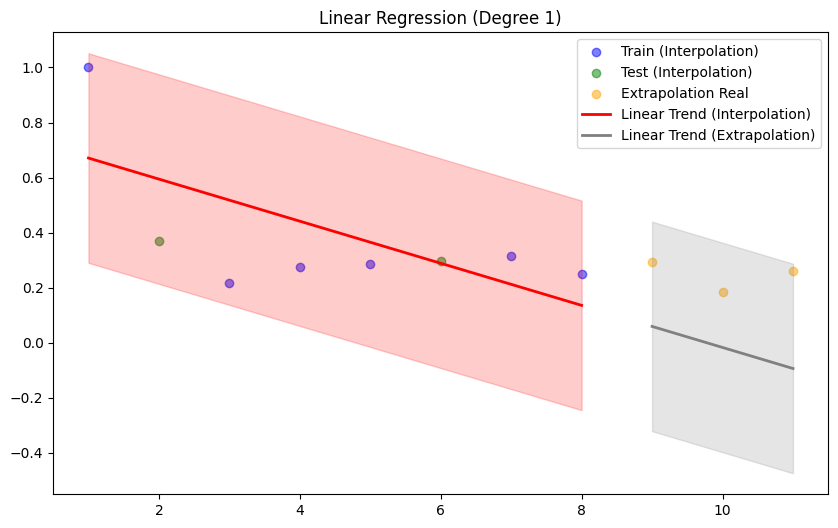

Degree 1:
 - Train MSE: 0.0427
 - Test MSE: 0.0257
 - R² Score (Train): 0.4321
 - R² Score (Test): -20.3091
The gap between the R2 scores of train and test is: 20.7412


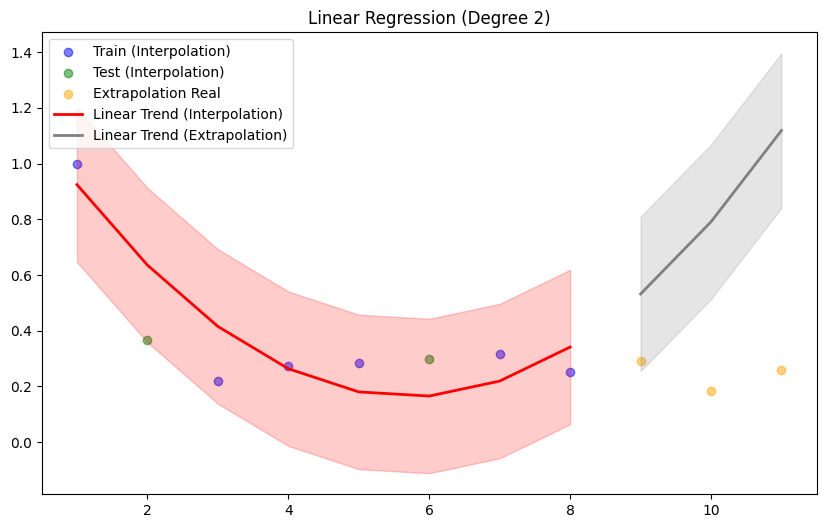

Degree 2:
 - Train MSE: 0.0122
 - Test MSE: 0.0447
 - R² Score (Train): 0.8379
 - R² Score (Test): -36.0504
The gap between the R2 scores of train and test is: 36.8883


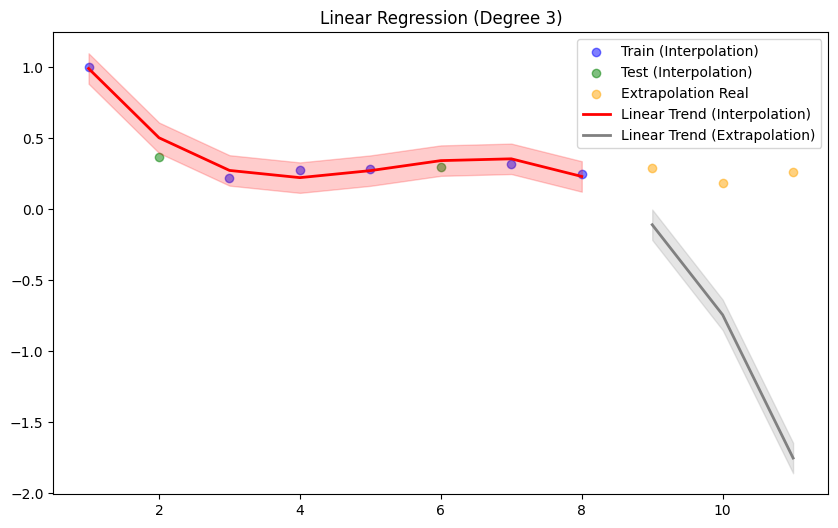

Degree 3:
 - Train MSE: 0.0013
 - Test MSE: 0.0101
 - R² Score (Train): 0.9827
 - R² Score (Test): -7.3389
The gap between the R2 scores of train and test is: 8.3217


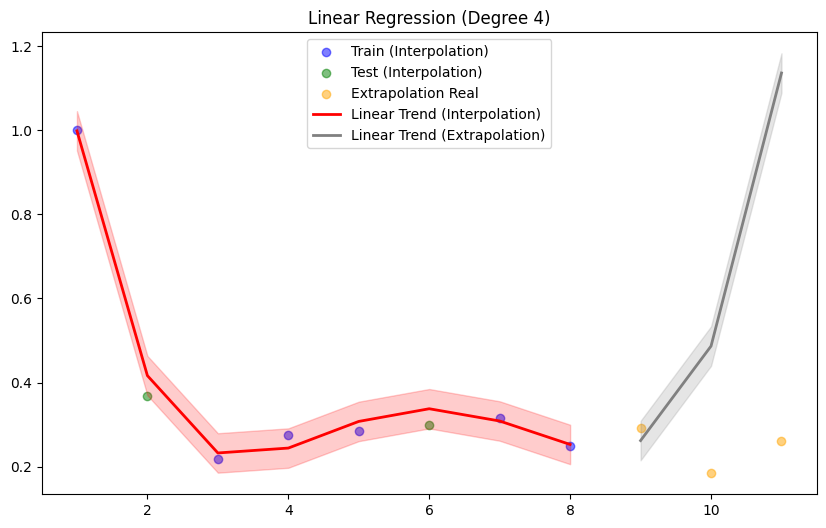

Degree 4:
 - Train MSE: 0.0003
 - Test MSE: 0.0019
 - R² Score (Train): 0.9963
 - R² Score (Test): -0.6002
The gap between the R2 scores of train and test is: 1.5965


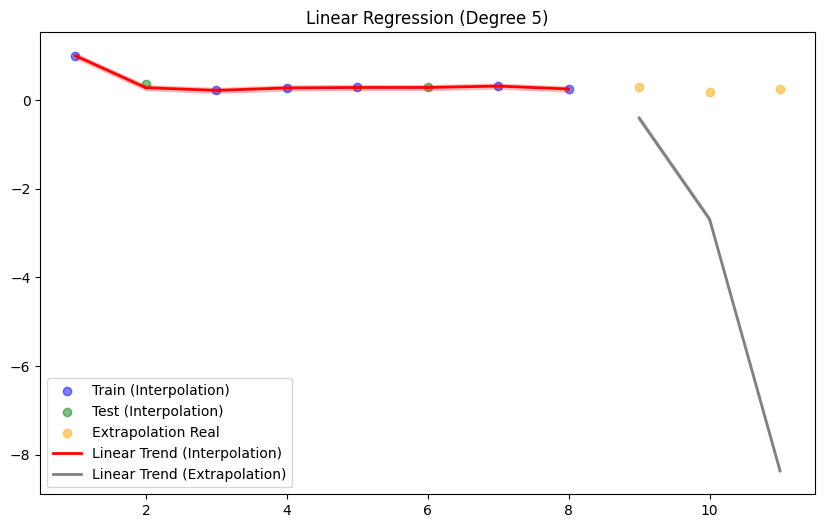

Degree 5:
 - Train MSE: 0.0000
 - Test MSE: 0.0040
 - R² Score (Train): 1.0000
 - R² Score (Test): -2.3229
The gap between the R2 scores of train and test is: 3.3229
The best linear regression model was for  5 degree


In [59]:
best_model = evaluate_polynomial_regression(df,'Month_Num','Retention_Rate')

In [60]:
model = best_model.named_steps['linearregression']
model = best_model.named_steps['linearregression']
model.coef_[5]= model.coef_[5] / 2


# try_best_model(best_model, df, 'Month_Num', 'Retention_Rate', exploration_size=0.1)

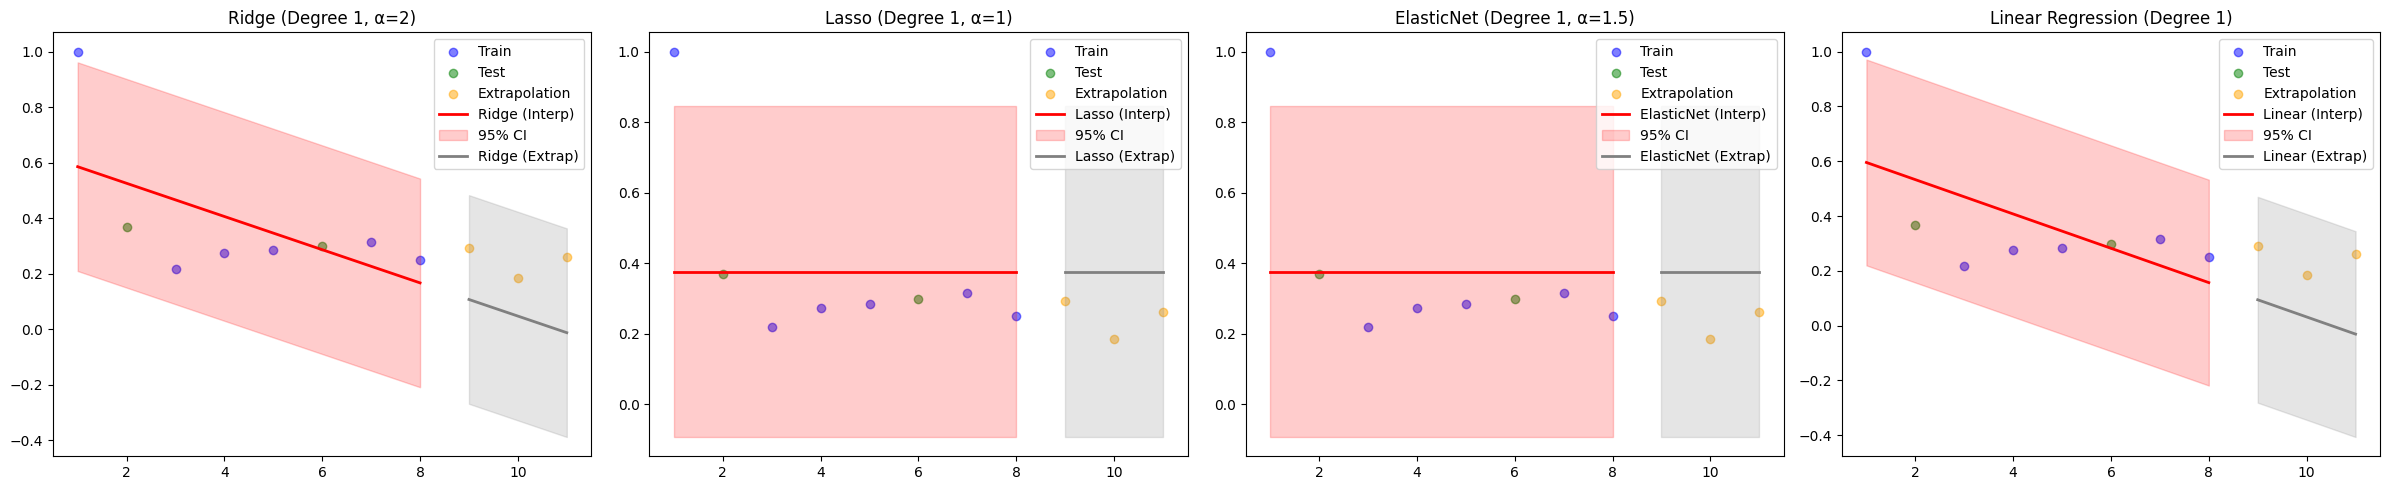

Degree 1:
  Ridge (α=2, MSE=0.1427), ΔR² train & test=9.7757
  Lasso (α=1, MSE=0.1024), ΔR² train & test=1.5287
  ElasticNet (α=1.5, MSE=0.1024), ΔR² train & test=1.5287
  Linear Regression (MSE=0.1498), ΔR² train & test=10.7835



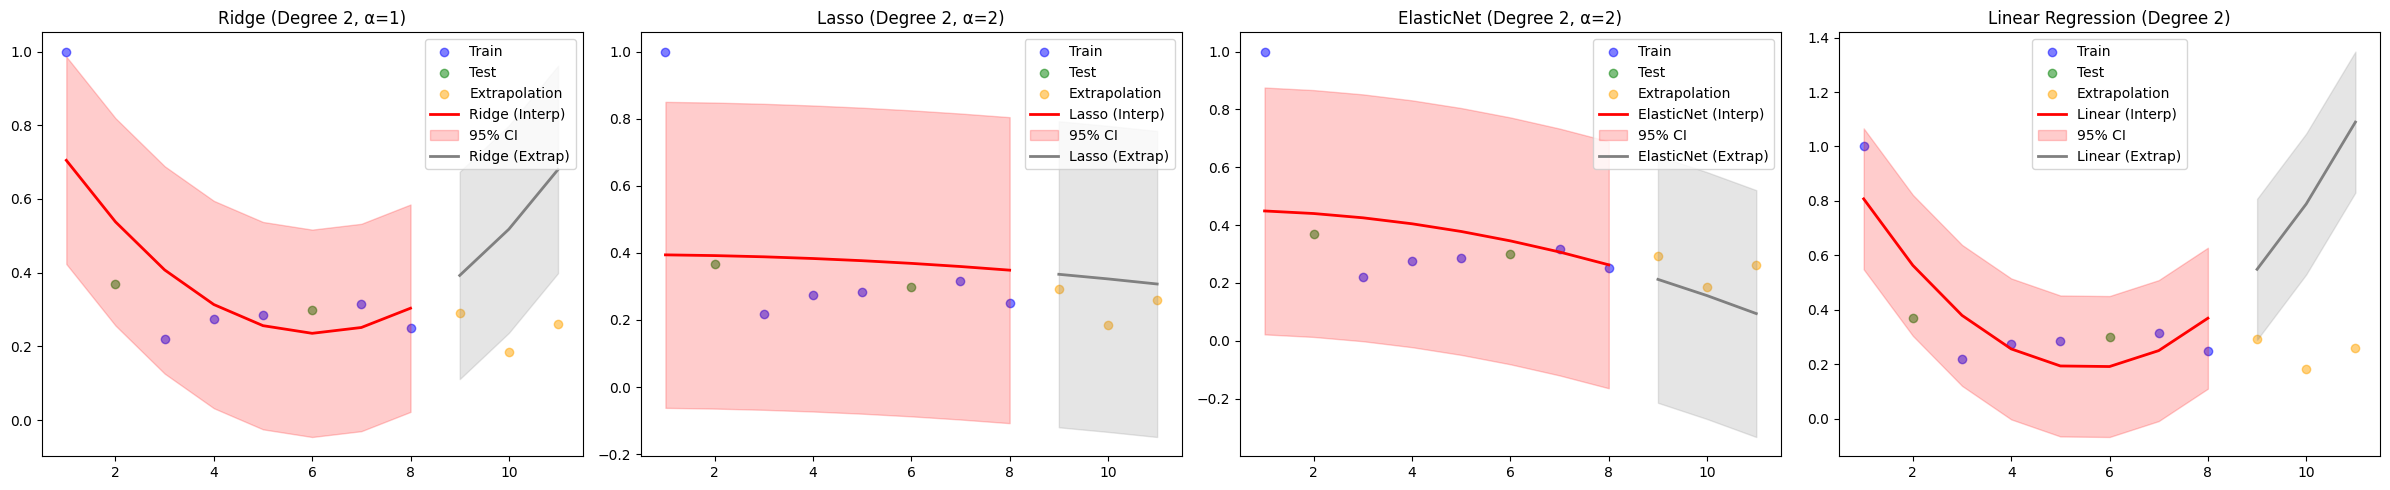

Degree 2:
  Ridge (α=1, MSE=0.1269), ΔR² train & test=13.3308
  Lasso (α=2, MSE=0.1128), ΔR² train & test=1.3239
  ElasticNet (α=2, MSE=0.1193), ΔR² train & test=2.2173
  Linear Regression (MSE=0.1555), ΔR² train & test=20.3391



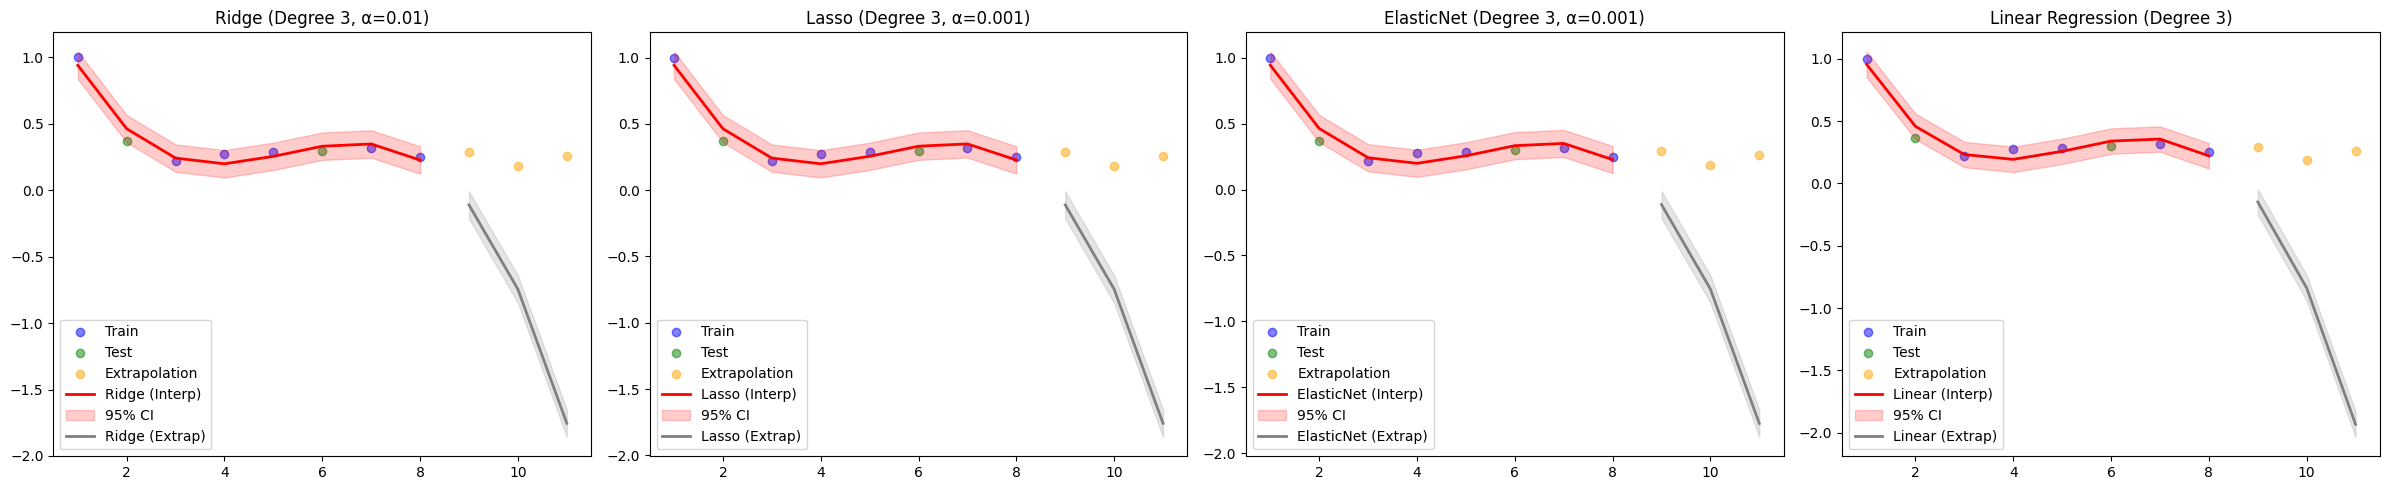

Degree 3:
  Ridge (α=0.01, MSE=0.1333), ΔR² train & test=4.1866
  Lasso (α=0.001, MSE=0.1227), ΔR² train & test=4.1847
  ElasticNet (α=0.001, MSE=0.1230), ΔR² train & test=4.1626
  Linear Regression (MSE=0.2401), ΔR² train & test=3.9812



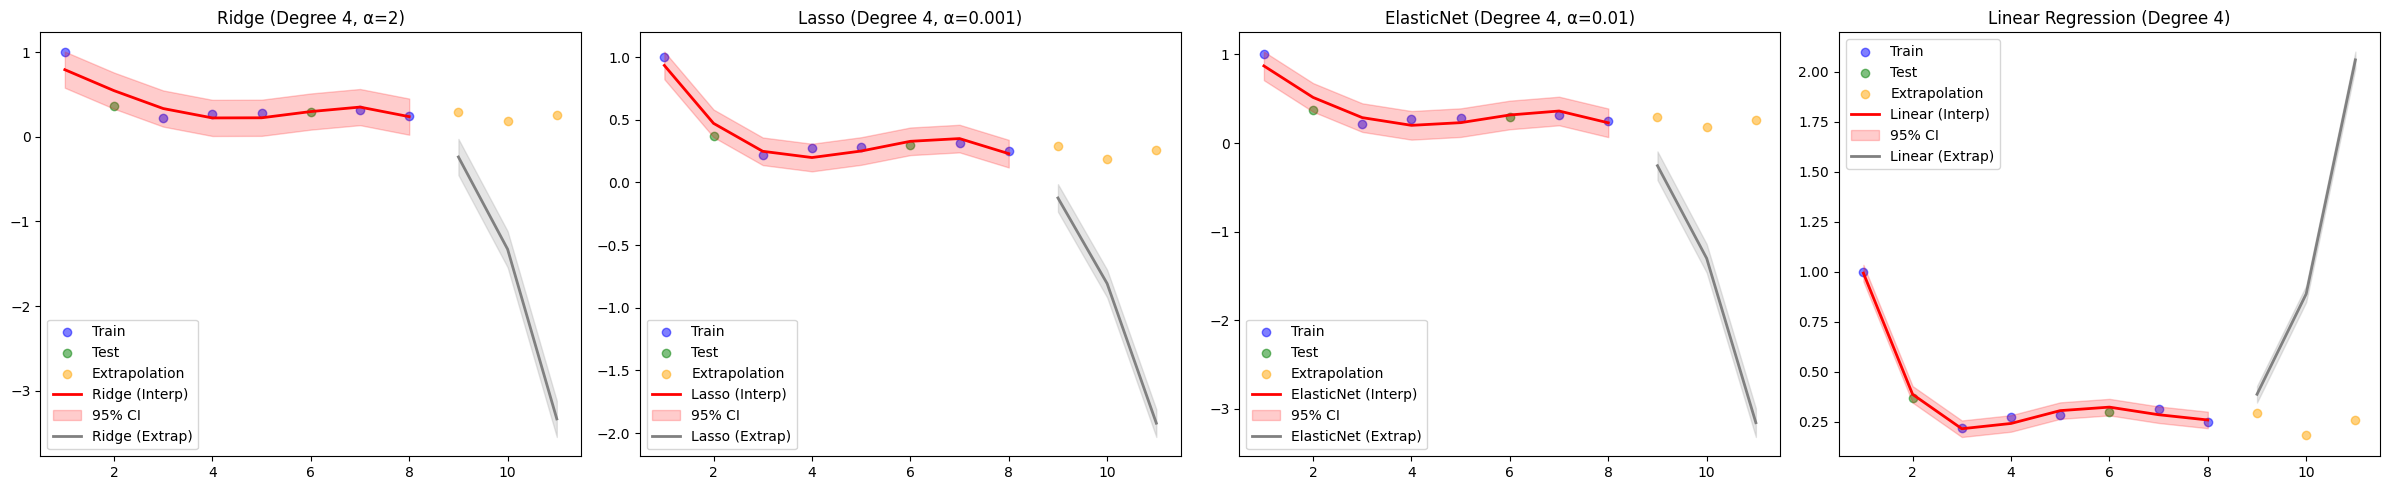

Degree 4:
  Ridge (α=2, MSE=0.1284), ΔR² train & test=12.9431
  Lasso (α=0.001, MSE=0.1241), ΔR² train & test=4.7568
  ElasticNet (α=0.01, MSE=0.1245), ΔR² train & test=9.0555
  Linear Regression (MSE=0.1870), ΔR² train & test=0.3951



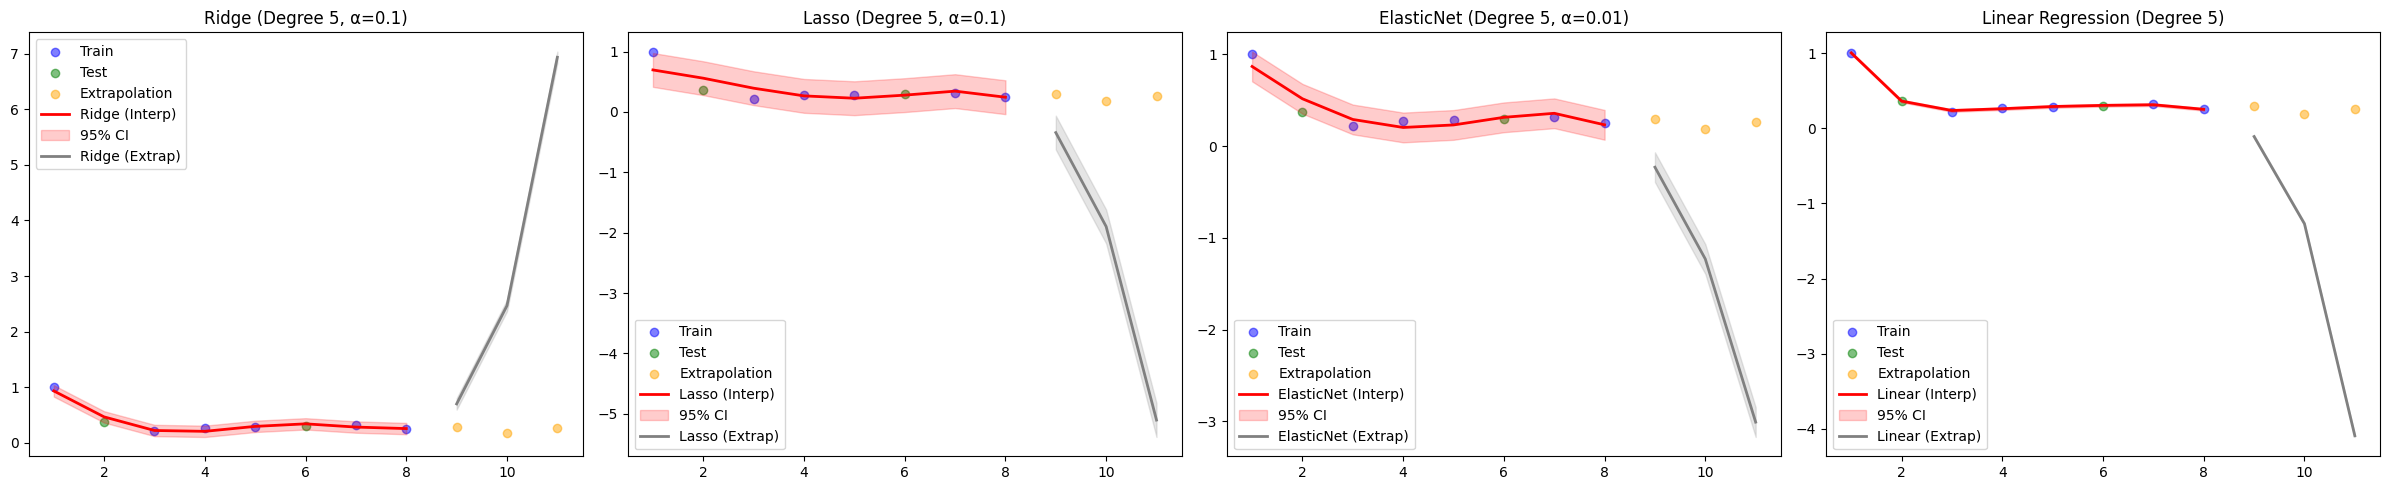

Degree 5:
  Ridge (α=0.1, MSE=0.1784), ΔR² train & test=4.8118
  Lasso (α=0.1, MSE=0.1330), ΔR² train & test=15.0556
  ElasticNet (α=0.01, MSE=0.1355), ΔR² train & test=9.0731
  Linear Regression (MSE=0.2233), ΔR² train & test=0.0335



Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

In [61]:
evaluate_regression_models(df,'Month_Num','Retention_Rate')

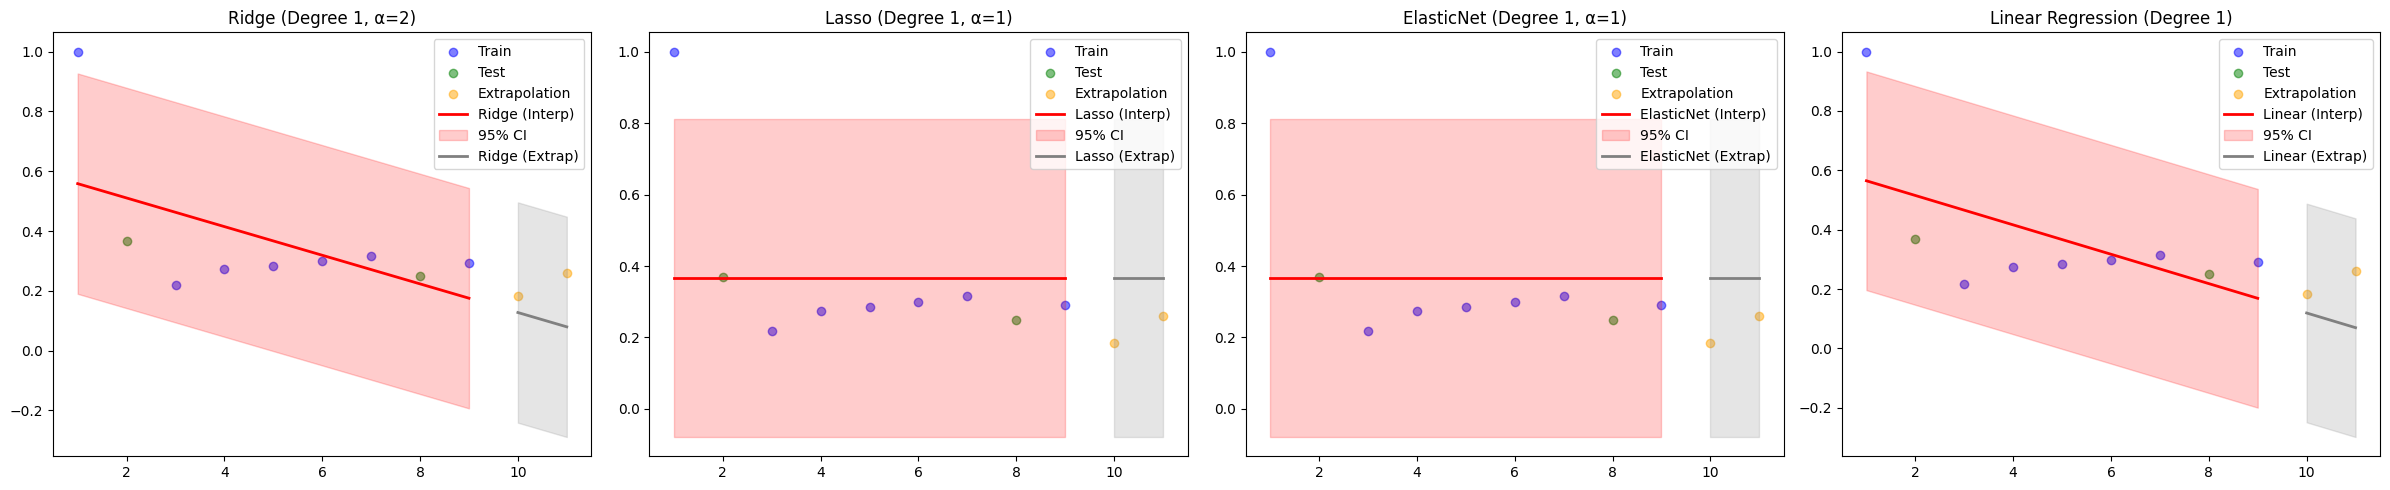

Degree 1:
  Ridge (α=2, MSE=0.1225), ΔR² train & test=2.3552
  Lasso (α=1, MSE=0.0884), ΔR² train & test=0.9569
  ElasticNet (α=1, MSE=0.0884), ΔR² train & test=0.9569
  Linear Regression (MSE=0.1277), ΔR² train & test=2.5984



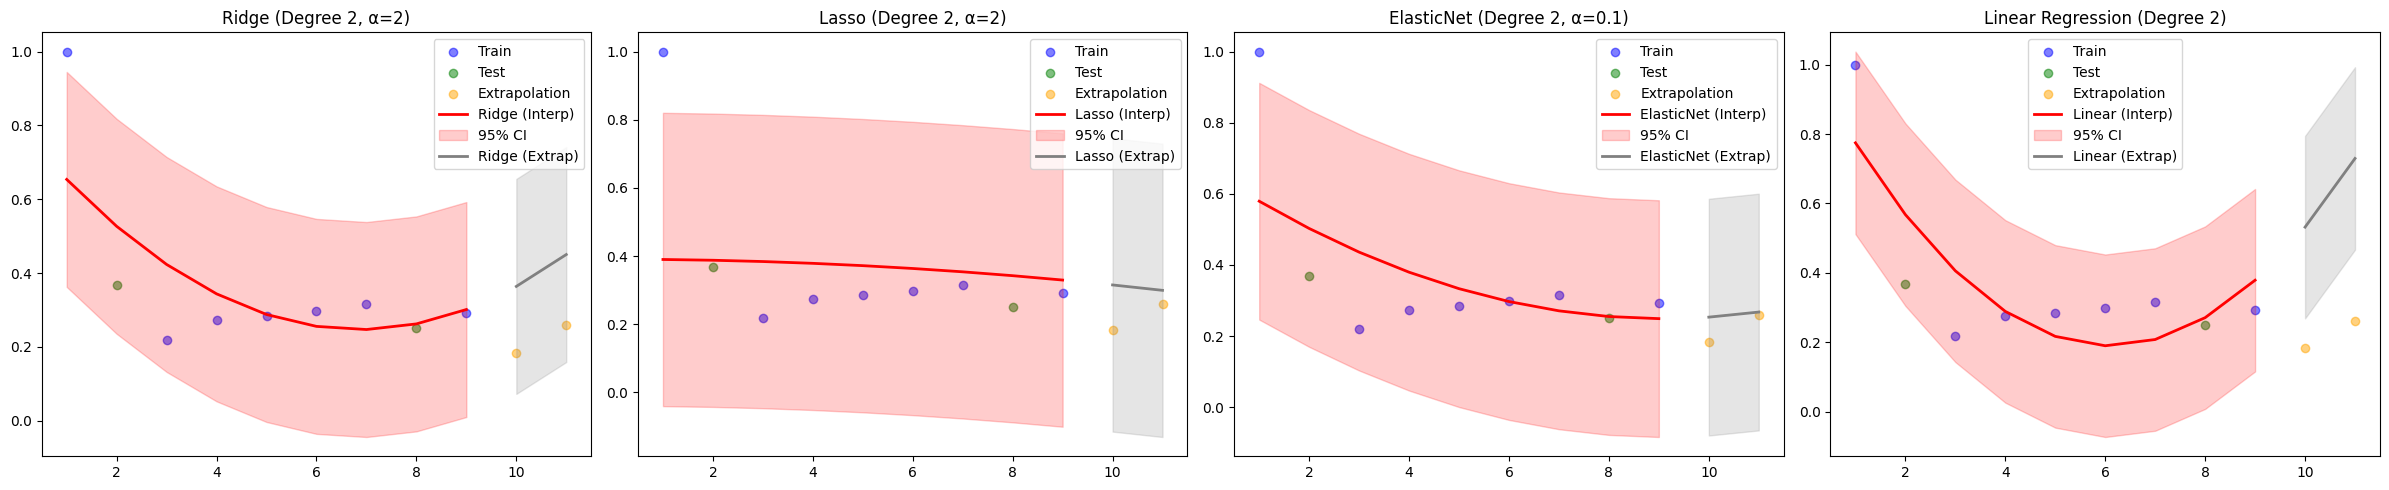

Degree 2:
  Ridge (α=2, MSE=0.1056), ΔR² train & test=3.2495
  Lasso (α=2, MSE=0.0919), ΔR² train & test=0.3373
  ElasticNet (α=0.1, MSE=0.0999), ΔR² train & test=2.0607
  Linear Regression (MSE=0.2045), ΔR² train & test=5.5182



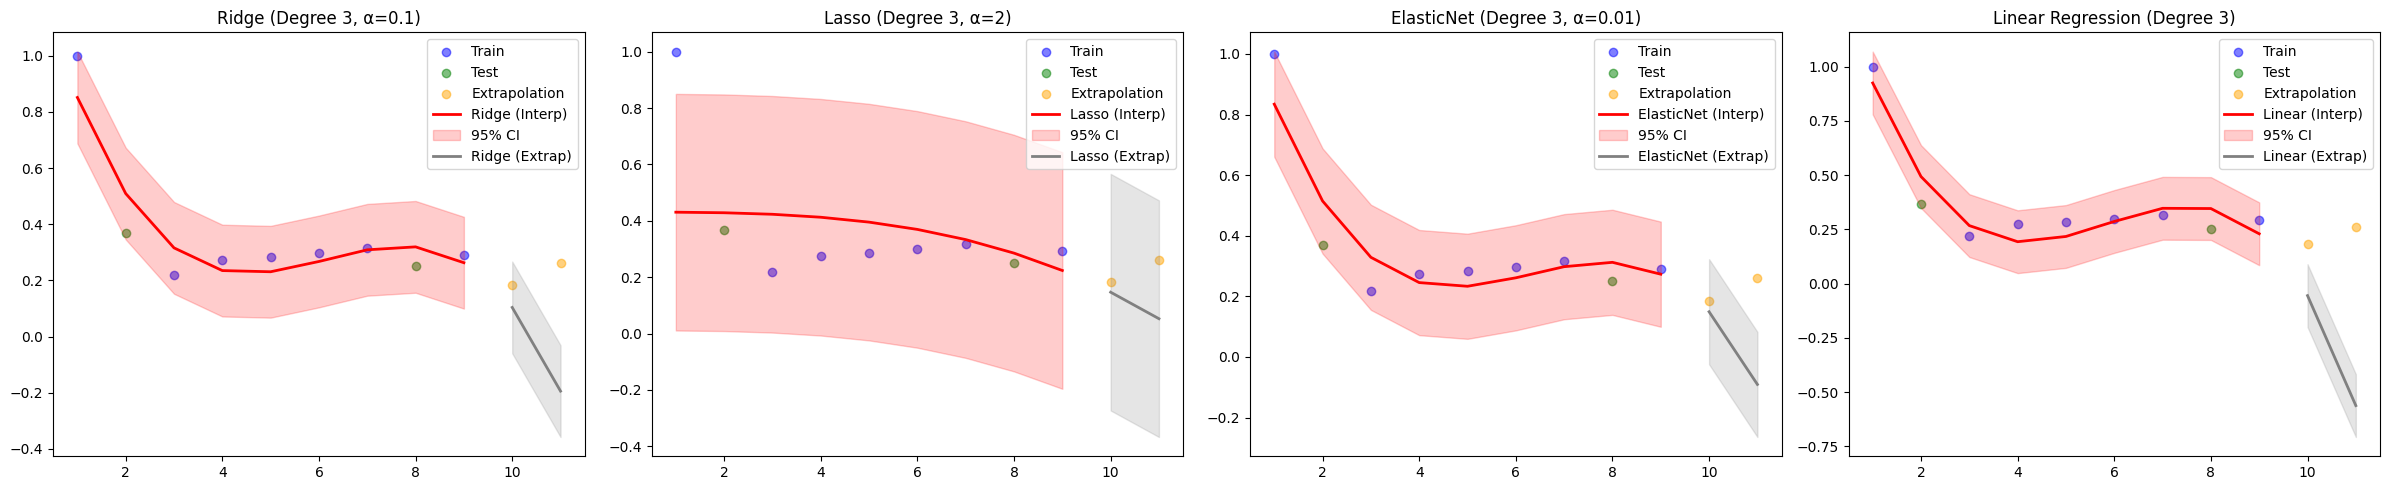

Degree 3:
  Ridge (α=0.1, MSE=0.1304), ΔR² train & test=3.4808
  Lasso (α=2, MSE=0.1261), ΔR² train & test=-0.2026
  ElasticNet (α=0.01, MSE=0.1159), ΔR² train & test=3.5500
  Linear Regression (MSE=0.1957), ΔR² train & test=3.5023



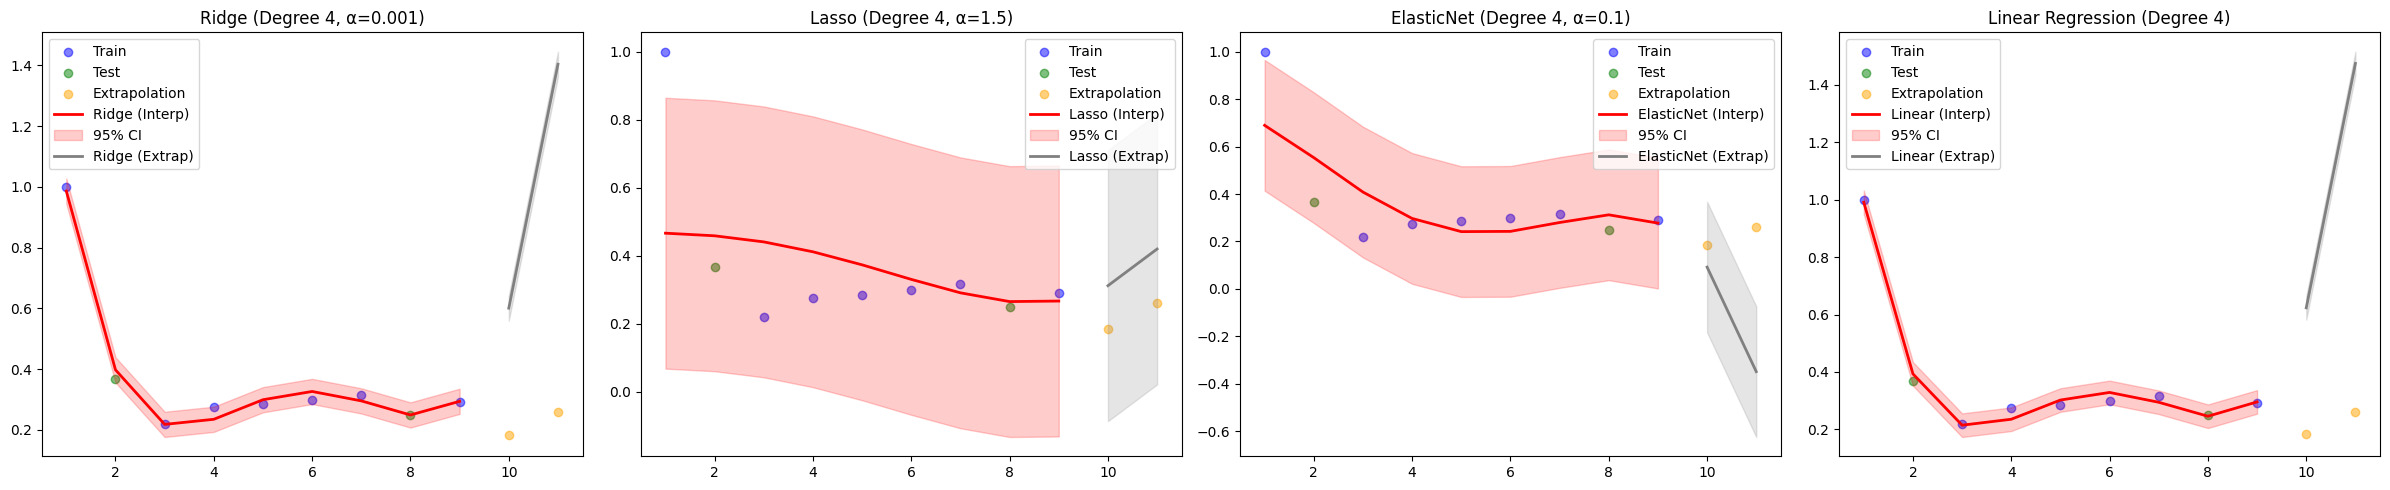

Degree 4:
  Ridge (α=0.001, MSE=0.1395), ΔR² train & test=0.1200
  Lasso (α=1.5, MSE=0.1136), ΔR² train & test=0.3962
  ElasticNet (α=0.1, MSE=0.1050), ΔR² train & test=5.1740
  Linear Regression (MSE=0.3396), ΔR² train & test=0.0869



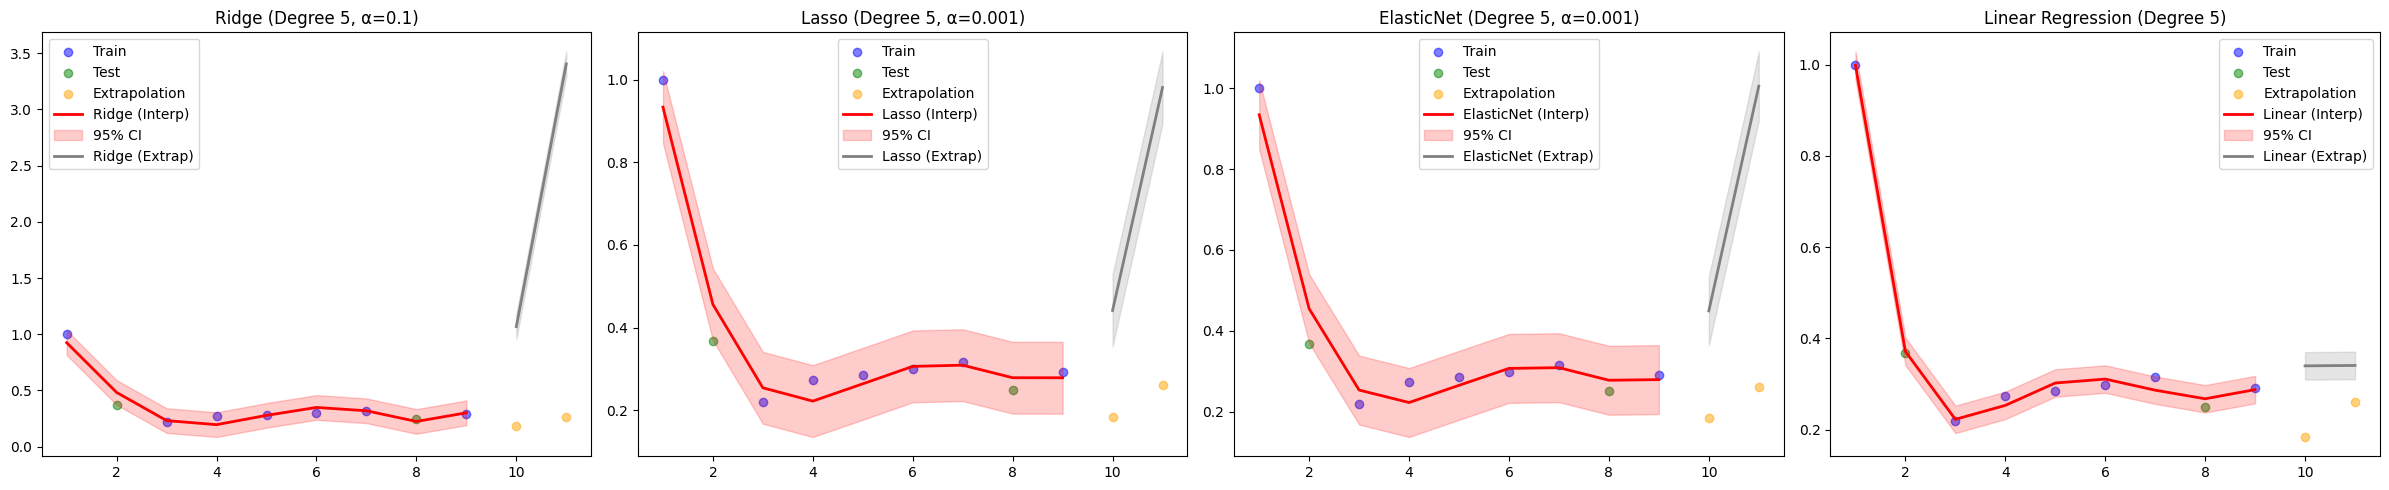

Degree 5:
  Ridge (α=0.1, MSE=0.2821), ΔR² train & test=1.9108
  Lasso (α=0.001, MSE=0.3415), ΔR² train & test=1.2083
  ElasticNet (α=0.001, MSE=0.3077), ΔR² train & test=1.1633
  Linear Regression (MSE=0.9832), ΔR² train & test=0.0433



In [62]:
best_model =evaluate_regression_models(df,'Month_Num','Retention_Rate', extrapolation_size = 0.1)

In [63]:
model = best_model.named_steps['linearregression']
print(model.coef_)
model.coef_[5]= model.coef_[5] / 2
print(model.coef_)


[ 0.00000000e+00 -2.26058239e+00  8.05665327e-01 -1.32458904e-01
  1.01976293e-02 -2.97142094e-04]
[ 0.00000000e+00 -2.26058239e+00  8.05665327e-01 -1.32458904e-01
  1.01976293e-02 -1.48571047e-04]


In [64]:
def fourier_transform(X, N=5):
    """Transforms X into Fourier basis functions up to N terms."""
    X = X.flatten()
    features = [np.ones_like(X)]  # Intercept term (bias term a0)
    
    for n in range(1, N + 1):
        features.append(np.sin(n * X))  # Sine terms
        features.append(np.cos(n * X))  # Cosine terms
    
    return np.column_stack(features)

In [65]:
from sklearn.preprocessing import FunctionTransformer

def evaluate_polynomial_regression_fourier(df, feature_col, target_col, poly_degree=[1, 2, 3, 4, 5], N_terms=4, random_state=42):
    """
    Trains and evaluates The Fourier Linear Regression model.
    Splits data into interpolation and extrapolation sets, computes metrics, and plots results.

    Parameters:
        df (DataFrame): Input data.
        feature_col (str): Feature column name.
        target_col (str): Target column name.
        N_terms (int): Number of Fourier terms to use.
        random_state (int): Seed for reproducibility.

    Returns:
        None (Plot the The linear regresssion model with fourrier series)
    """
    df_train = df.dropna()  # Remove NaN values

    # Convert to numpy arrays
    X = np.array(df_train[feature_col]).reshape(-1, 1)
    y = np.array(df_train[target_col])

    # Split dataset into 80% interpolation and 20% extrapolation
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, shuffle=True, random_state=random_state)

    # Fourier Features Transformer
    fourier_features = FunctionTransformer(lambda x: fourier_transform(x, N=N_terms), validate=True)
    fourier_model = make_pipeline(fourier_features, LinearRegression())

    # Train Fourier Model
    fourier_model.fit(X_train, y_train)

    # Fourier Predictions
    fourier_train_preds = fourier_model.predict(X_train)
    fourier_test_preds = fourier_model.predict(X_test)
    fourier_y_predict_interp = fourier_model.predict(X_interp)
    fourier_y_predict_extra = fourier_model.predict(X_extrap)

    # Compute Fourier Performance Metrics
    fourier_mse_train = mean_squared_error(y_train, fourier_train_preds)
    fourier_mse_test = mean_squared_error(y_test, fourier_test_preds)
    R2_fourier_train = r2_score(y_train, fourier_train_preds)
    R2_fourier_test = r2_score(y_test, fourier_test_preds)
    R2_fourier_extrap = r2_score(y_extrap, fourier_y_predict_extra)

    print("=== Fourier Regression ===")
    print(f" - Train MSE: {fourier_mse_train:.4f}")
    print(f" - Test MSE: {fourier_mse_test:.4f}")
    print(f" - R² Score (Train): {R2_fourier_train:.4f}")
    print(f" - R² Score (Test): {R2_fourier_test:.4f}")
    print(f" - R² Score (Extrapolation): {R2_fourier_extrap:.4f}")
    print("=" * 60)

In [66]:
cohort_2020_01 = retention_request.loc['2020-01']
df_2020_01 = cohort_2020_01.reset_index()

df_2020_01.columns = ['Month', 'Retention_Rate']
df_2020_01 = df_2020_01.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_01['Month'] = df_2020_01['Month'].astype(str)  # Convert to string
df_2020_01['Month'] = pd.to_datetime(df_2020_01['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_01['Month_Num'] = (df_2020_01['Month'] - df_2020_01['Month'].min()).dt.days // 30

df_2020_01

Month  Retention_Rate  Month_Num
0  2019-11-01             NaN          0
1  2019-12-01             NaN          1
2  2020-01-01        1.000000          2
3  2020-02-01        0.205128          3
4  2020-03-01        0.145299          4
5  2020-04-01        0.299145          5
6  2020-05-01        0.264957          6
7  2020-06-01        0.247863          7
8  2020-07-01        0.264957          8
9  2020-08-01        0.188034          9
10 2020-09-01        0.188034         10
11 2020-10-01        0.213675         11

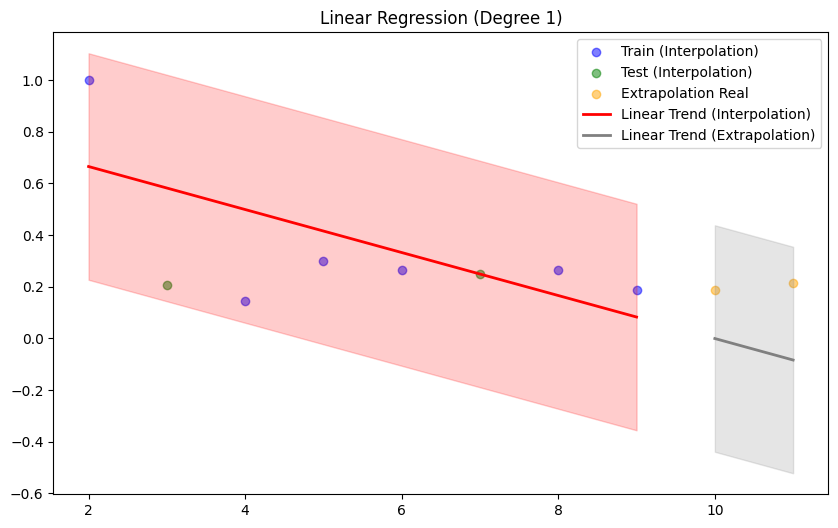

Degree 1:
 - Train MSE: 0.0460
 - Test MSE: 0.0712
 - R² Score (Train): 0.4556
 - R² Score (Test): -154.8698
The gap between the R2 scores of train and test is: 155.3254


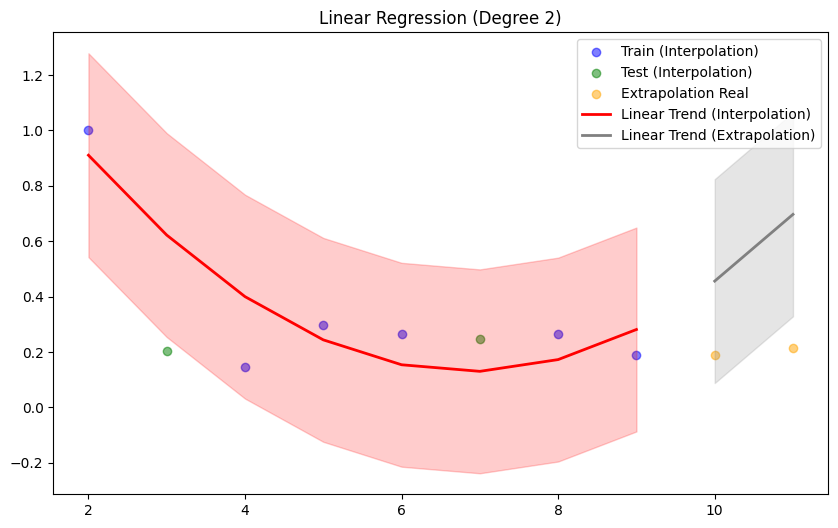

Degree 2:
 - Train MSE: 0.0176
 - Test MSE: 0.0938
 - R² Score (Train): 0.7921
 - R² Score (Test): -204.5064
The gap between the R2 scores of train and test is: 205.2985


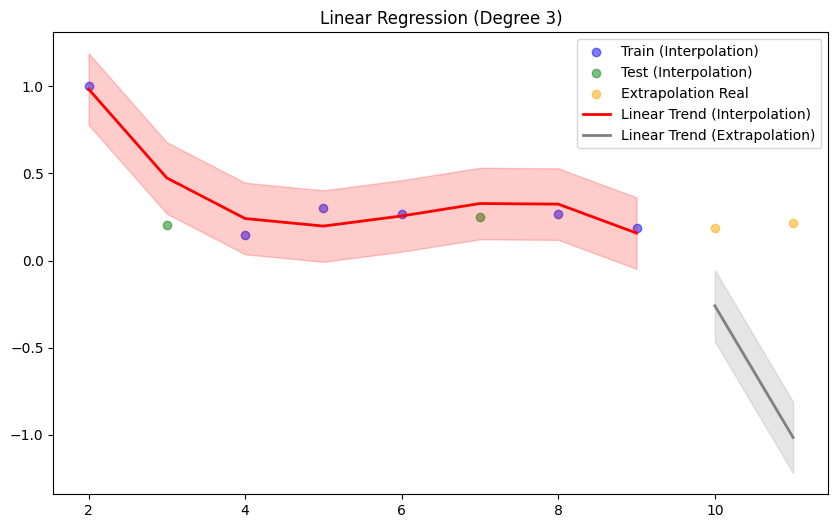

Degree 3:
 - Train MSE: 0.0040
 - Test MSE: 0.0394
 - R² Score (Train): 0.9523
 - R² Score (Test): -85.2199
The gap between the R2 scores of train and test is: 86.1722


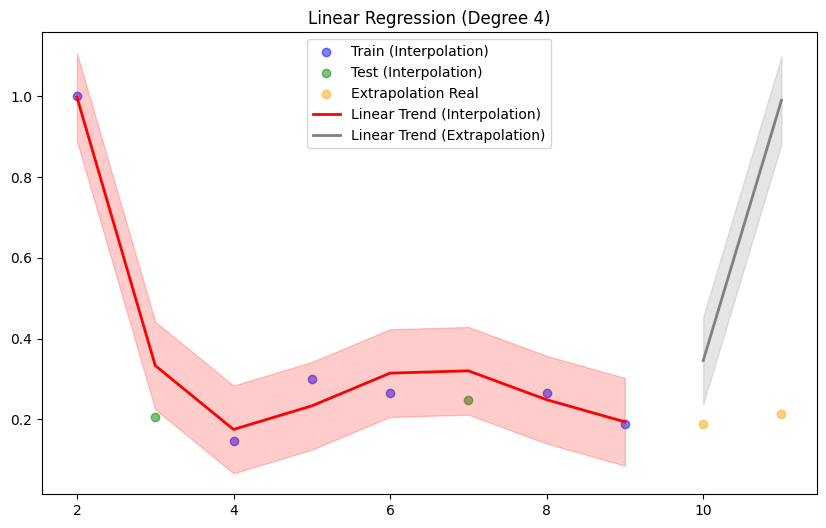

Degree 4:
 - Train MSE: 0.0013
 - Test MSE: 0.0108
 - R² Score (Train): 0.9843
 - R² Score (Test): -22.6352
The gap between the R2 scores of train and test is: 23.6195


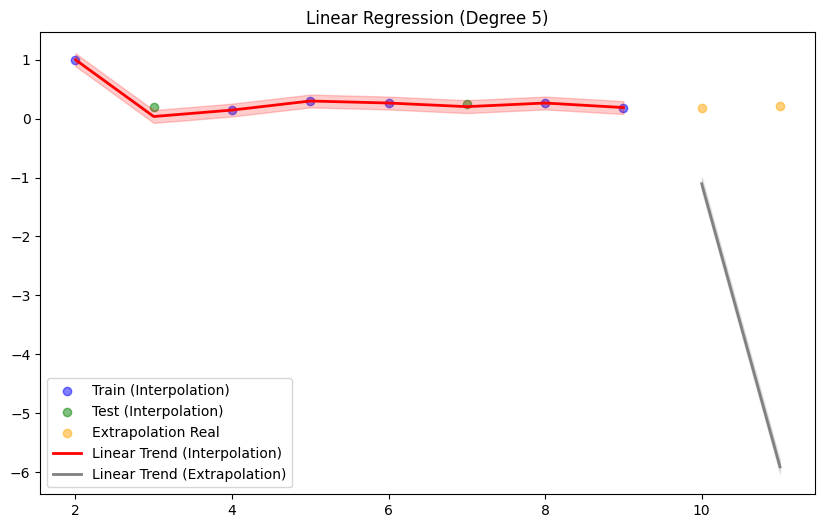

Degree 5:
 - Train MSE: 0.0000
 - Test MSE: 0.0153
 - R² Score (Train): 1.0000
 - R² Score (Test): -32.4931
The gap between the R2 scores of train and test is: 33.4931
The best linear regression model was for  5 degree


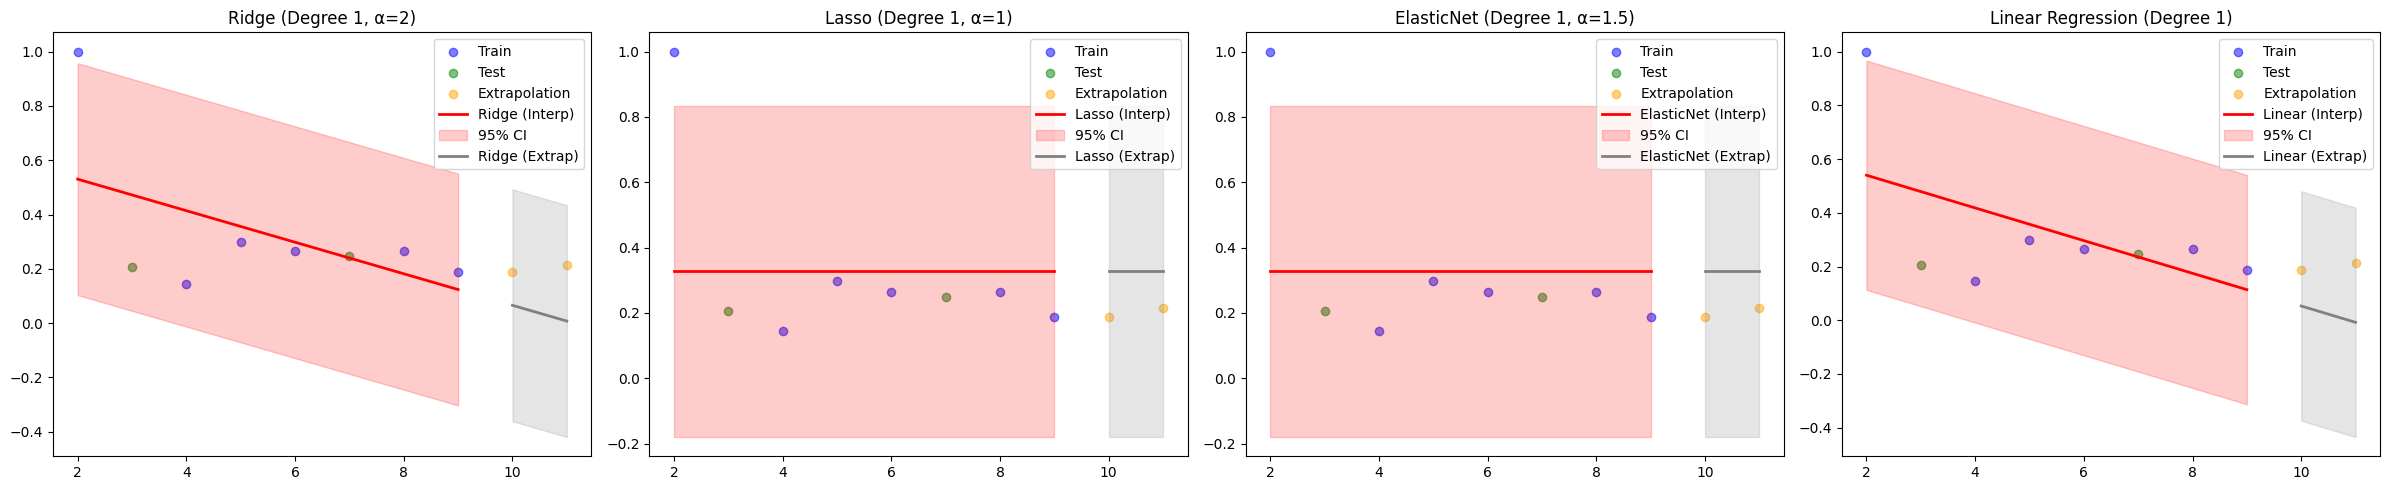

Degree 1:
  Ridge (α=2, MSE=0.1564), ΔR² train & test=77.5313
  Lasso (α=1, MSE=0.1123), ΔR² train & test=22.0767
  ElasticNet (α=1.5, MSE=0.1123), ΔR² train & test=22.0767
  Linear Regression (MSE=0.1640), ΔR² train & test=81.7274



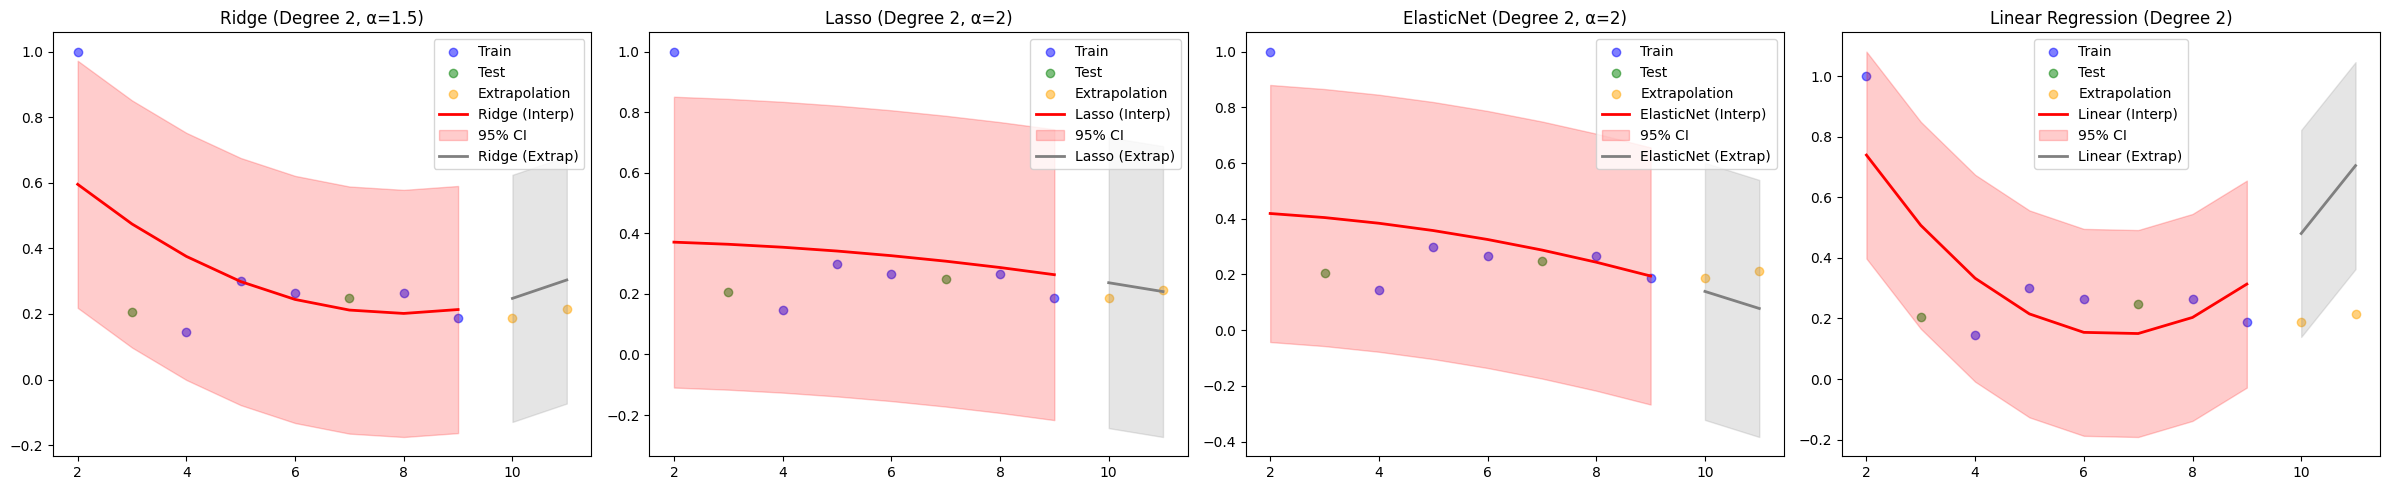

Degree 2:
  Ridge (α=1.5, MSE=0.1485), ΔR² train & test=80.3647
  Lasso (α=2, MSE=0.1289), ΔR² train & test=30.6871
  ElasticNet (α=2, MSE=0.1351), ΔR² train & test=44.3150
  Linear Regression (MSE=0.2529), ΔR² train & test=110.3139



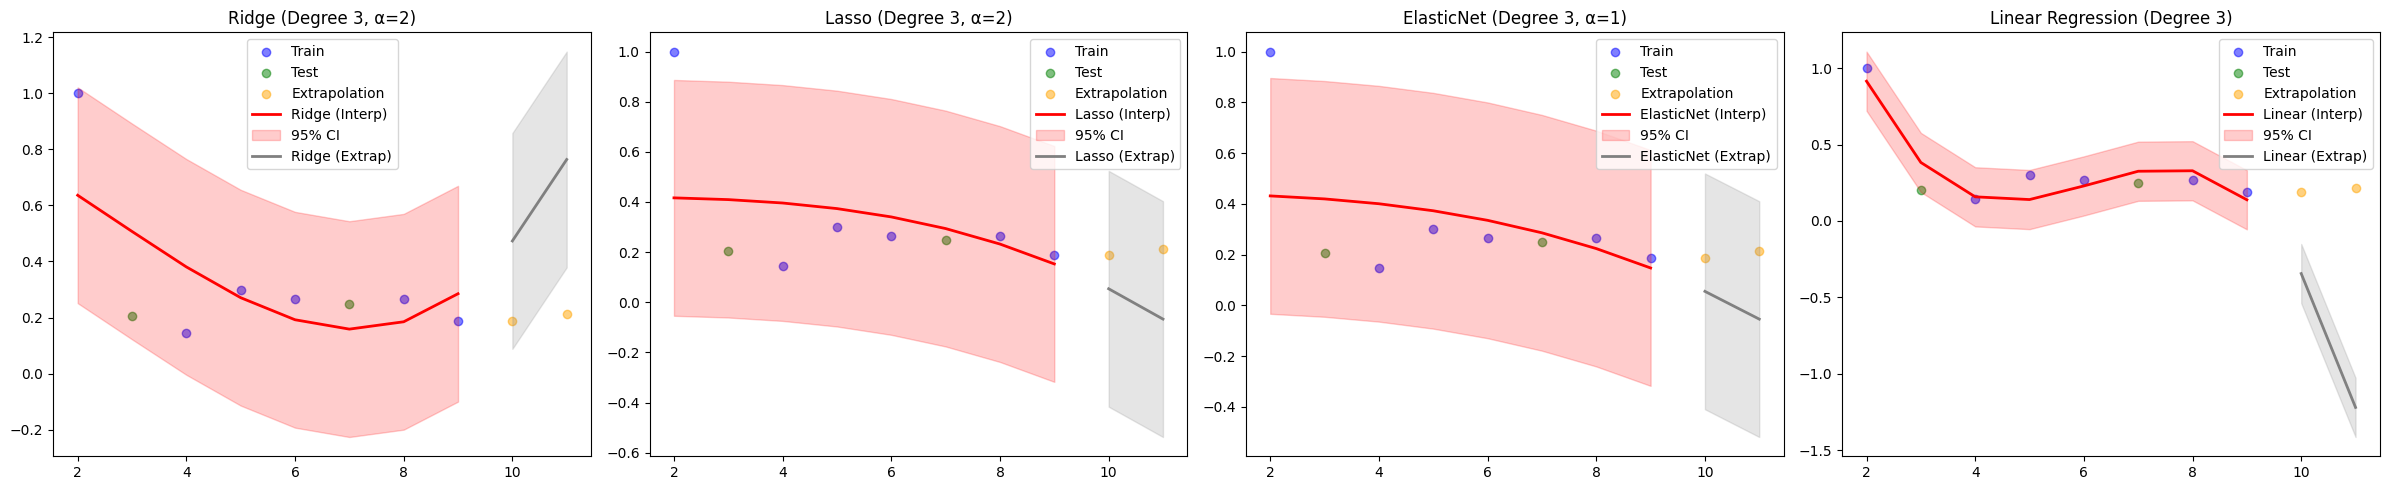

Degree 3:
  Ridge (α=2, MSE=0.2014), ΔR² train & test=108.2690
  Lasso (α=2, MSE=0.1426), ΔR² train & test=47.2709
  ElasticNet (α=1, MSE=0.1443), ΔR² train & test=51.0626
  Linear Regression (MSE=0.9768), ΔR² train & test=40.9366



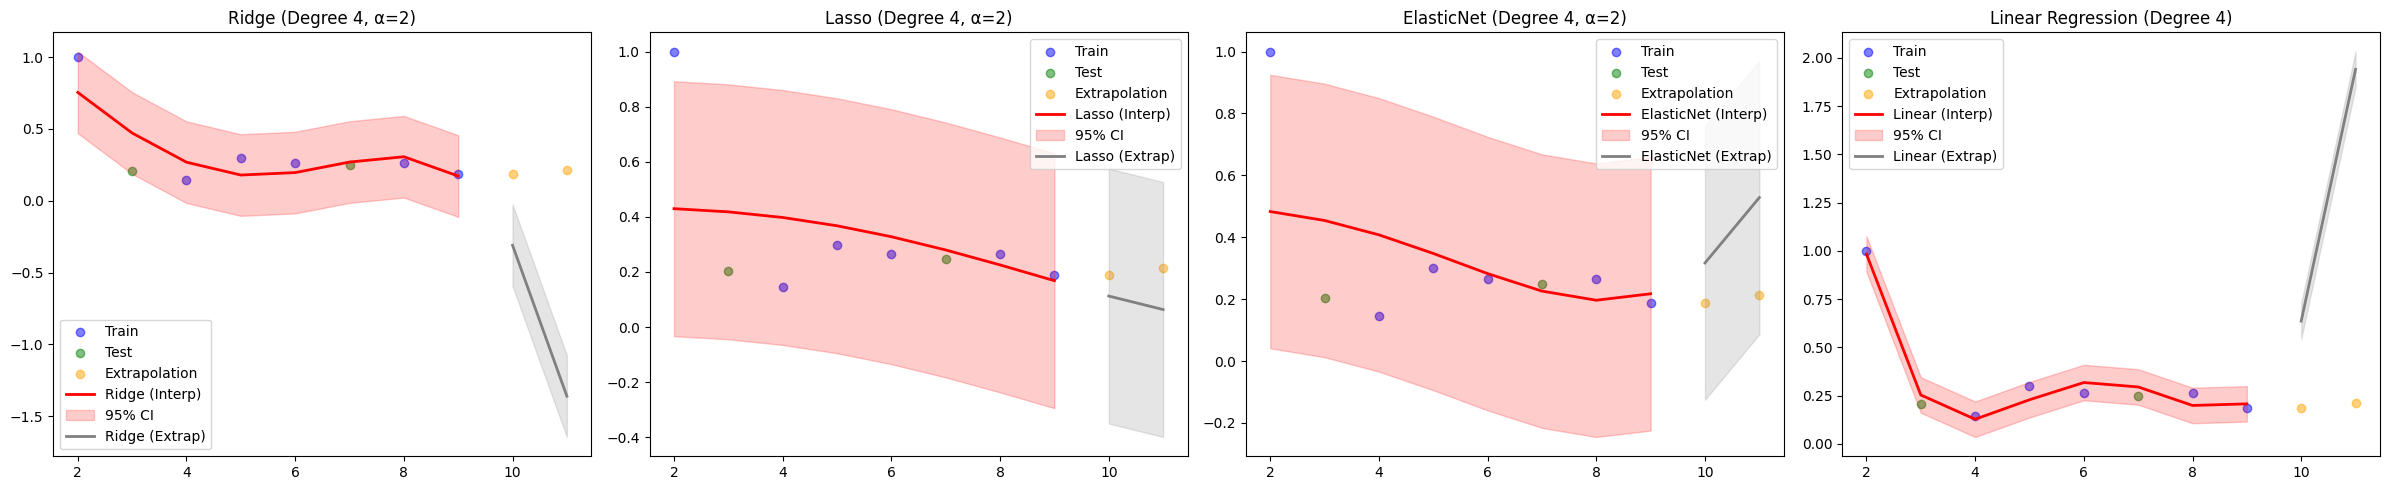

Degree 4:
  Ridge (α=2, MSE=0.1799), ΔR² train & test=77.8834
  Lasso (α=2, MSE=0.1489), ΔR² train & test=50.0683
  ElasticNet (α=2, MSE=0.1551), ΔR² train & test=67.8034
  Linear Regression (MSE=0.6598), ΔR² train & test=5.0424



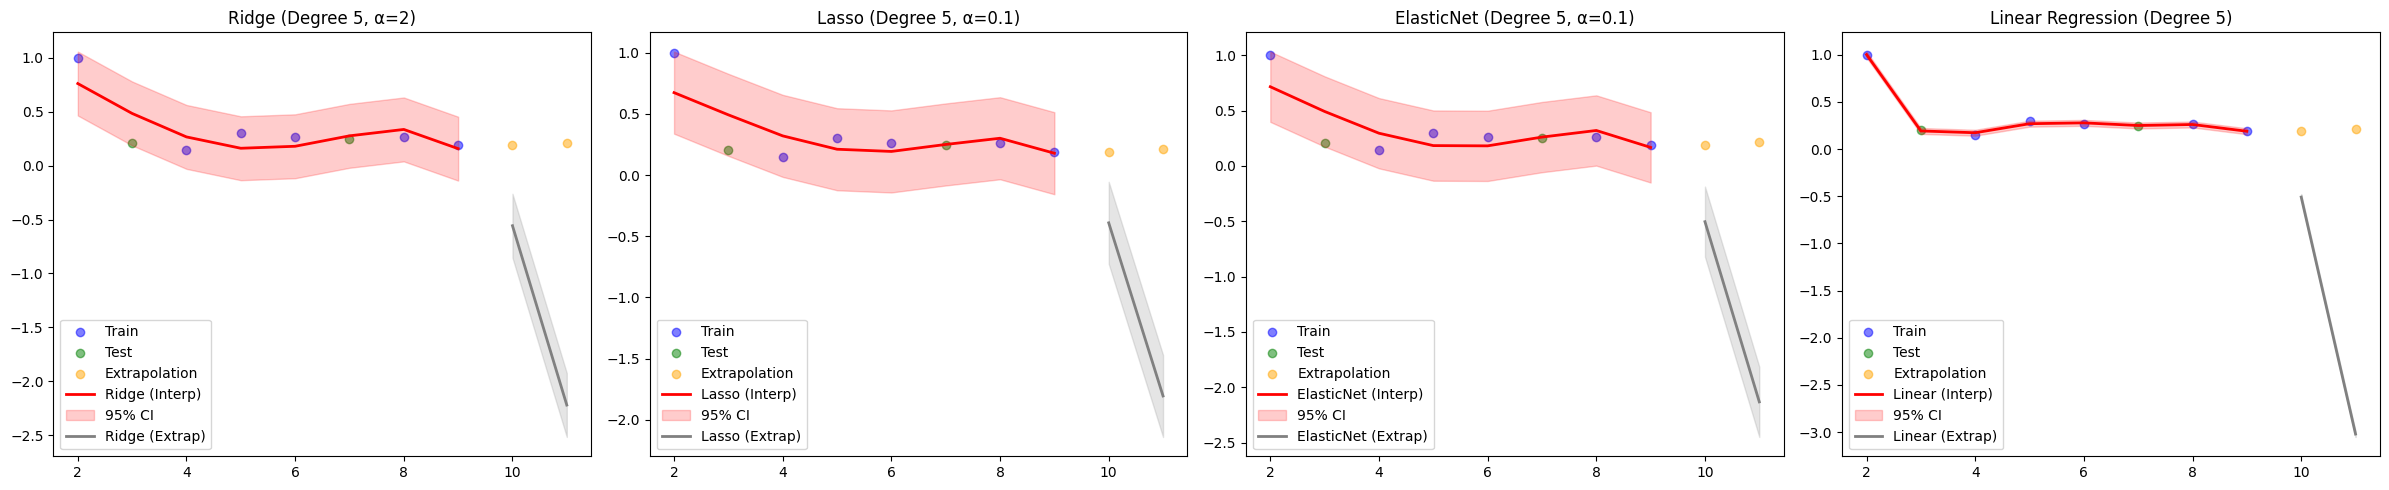

Degree 5:
  Ridge (α=2, MSE=0.4050), ΔR² train & test=85.2506
  Lasso (α=0.1, MSE=0.1716), ΔR² train & test=89.4678
  ElasticNet (α=0.1, MSE=0.1760), ΔR² train & test=90.0142
  Linear Regression (MSE=0.6992), ΔR² train & test=0.1793



Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

In [67]:
evaluate_polynomial_regression(df_2020_01,'Month_Num','Retention_Rate')
evaluate_regression_models(df_2020_01,'Month_Num','Retention_Rate')

In [68]:
cohort_2020_02 = retention_request.loc['2020-02']
df_2020_02 = cohort_2020_02.reset_index()

df_2020_02.columns = ['Month', 'Retention_Rate']
df_2020_02 = df_2020_02.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_02['Month'] = df_2020_02['Month'].astype(str)  # Convert to string
df_2020_02['Month'] = pd.to_datetime(df_2020_02['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_02['Month_Num'] = (df_2020_02['Month'] - df_2020_02['Month'].min()).dt.days // 30
df_2020_02['Month_Num'] = df_2020_02['Month_Num'].astype(int)
df_2020_02


Month  Retention_Rate  Month_Num
0  2019-11-01             NaN          0
1  2019-12-01             NaN          1
2  2020-01-01             NaN          2
3  2020-02-01        1.000000          3
4  2020-03-01        0.505155          4
5  2020-04-01        0.505155          5
6  2020-05-01        0.463918          6
7  2020-06-01        0.463918          7
8  2020-07-01        0.463918          8
9  2020-08-01        0.453608          9
10 2020-09-01        0.278351         10
11 2020-10-01        0.412371         11

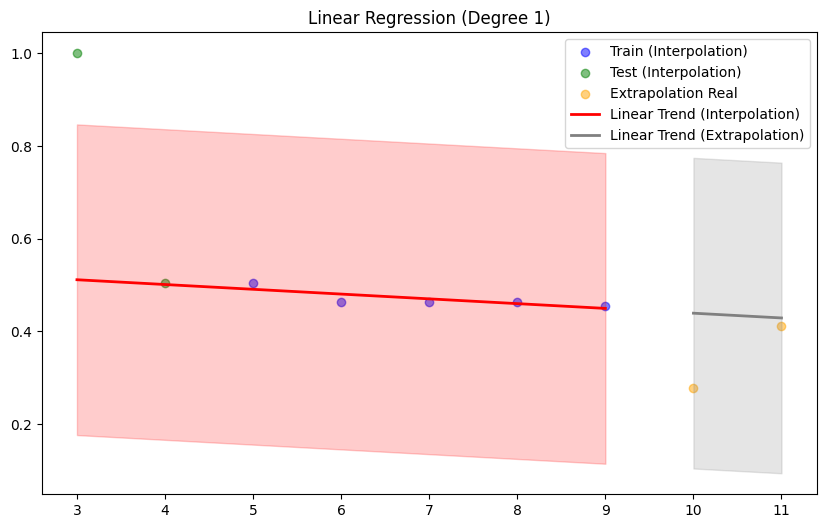

Degree 1:
 - Train MSE: 0.0001
 - Test MSE: 0.1194
 - R² Score (Train): 0.6579
 - R² Score (Test): -0.9505
The gap between the R2 scores of train and test is: 1.6083


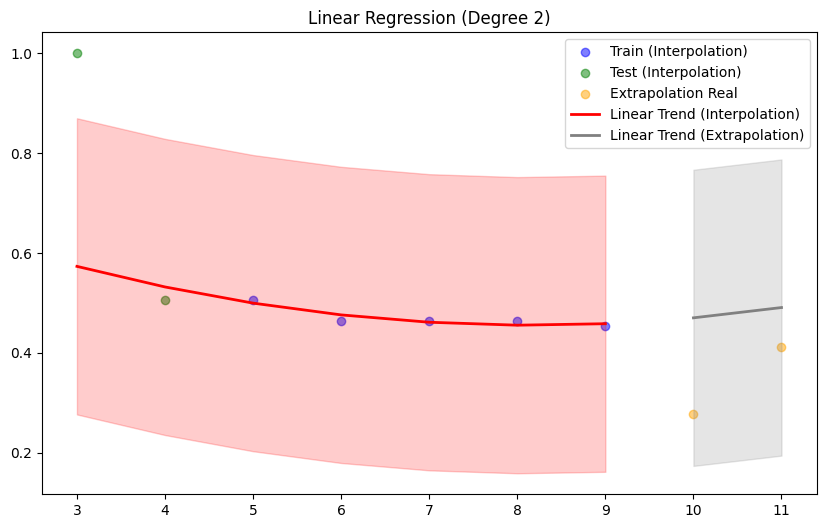

Degree 2:
 - Train MSE: 0.0001
 - Test MSE: 0.0914
 - R² Score (Train): 0.8271
 - R² Score (Test): -0.4937
The gap between the R2 scores of train and test is: 1.3207


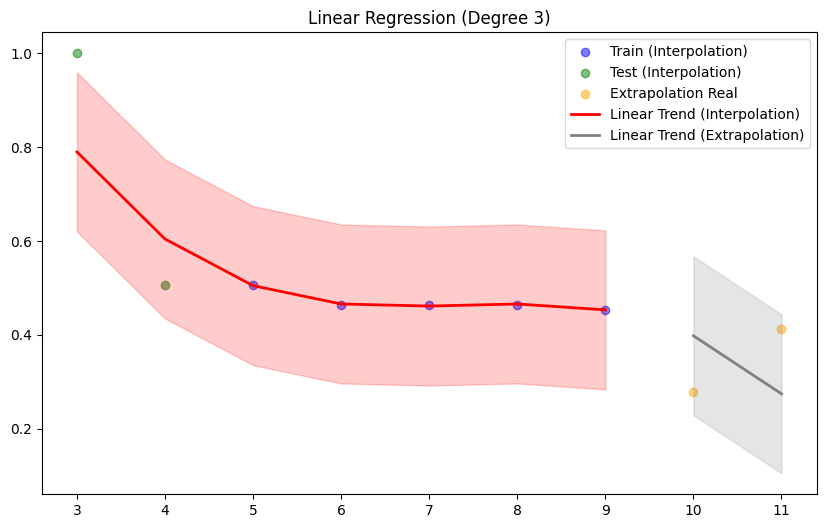

Degree 3:
 - Train MSE: 0.0000
 - Test MSE: 0.0270
 - R² Score (Train): 0.9915
 - R² Score (Test): 0.5588
The gap between the R2 scores of train and test is: 0.4328


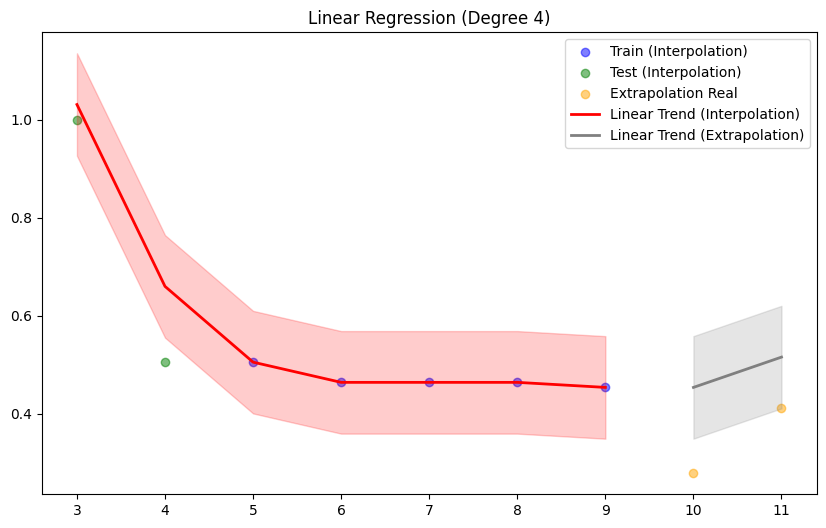

Degree 4:
 - Train MSE: 0.0000
 - Test MSE: 0.0124
 - R² Score (Train): 1.0000
 - R² Score (Test): 0.7969
The gap between the R2 scores of train and test is: 0.2031


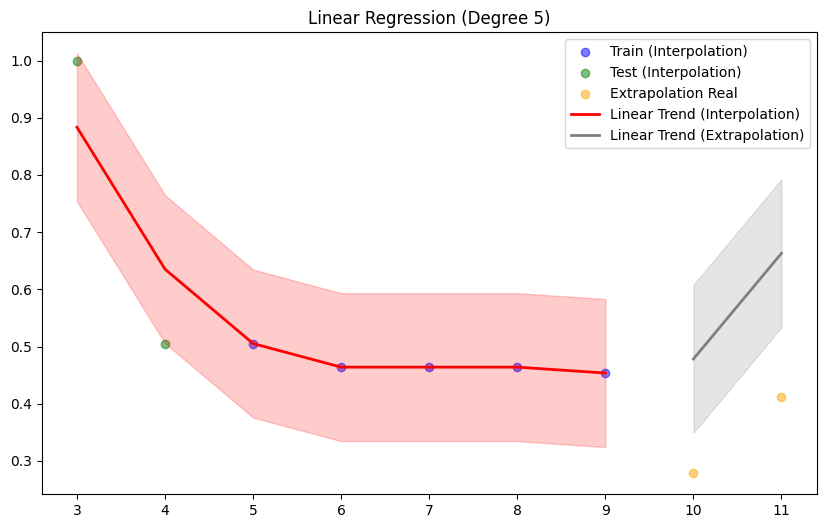

Degree 5:
 - Train MSE: 0.0000
 - Test MSE: 0.0153
 - R² Score (Train): 1.0000
 - R² Score (Test): 0.7507
The gap between the R2 scores of train and test is: 0.2493
The best linear regression model was for  5 degree


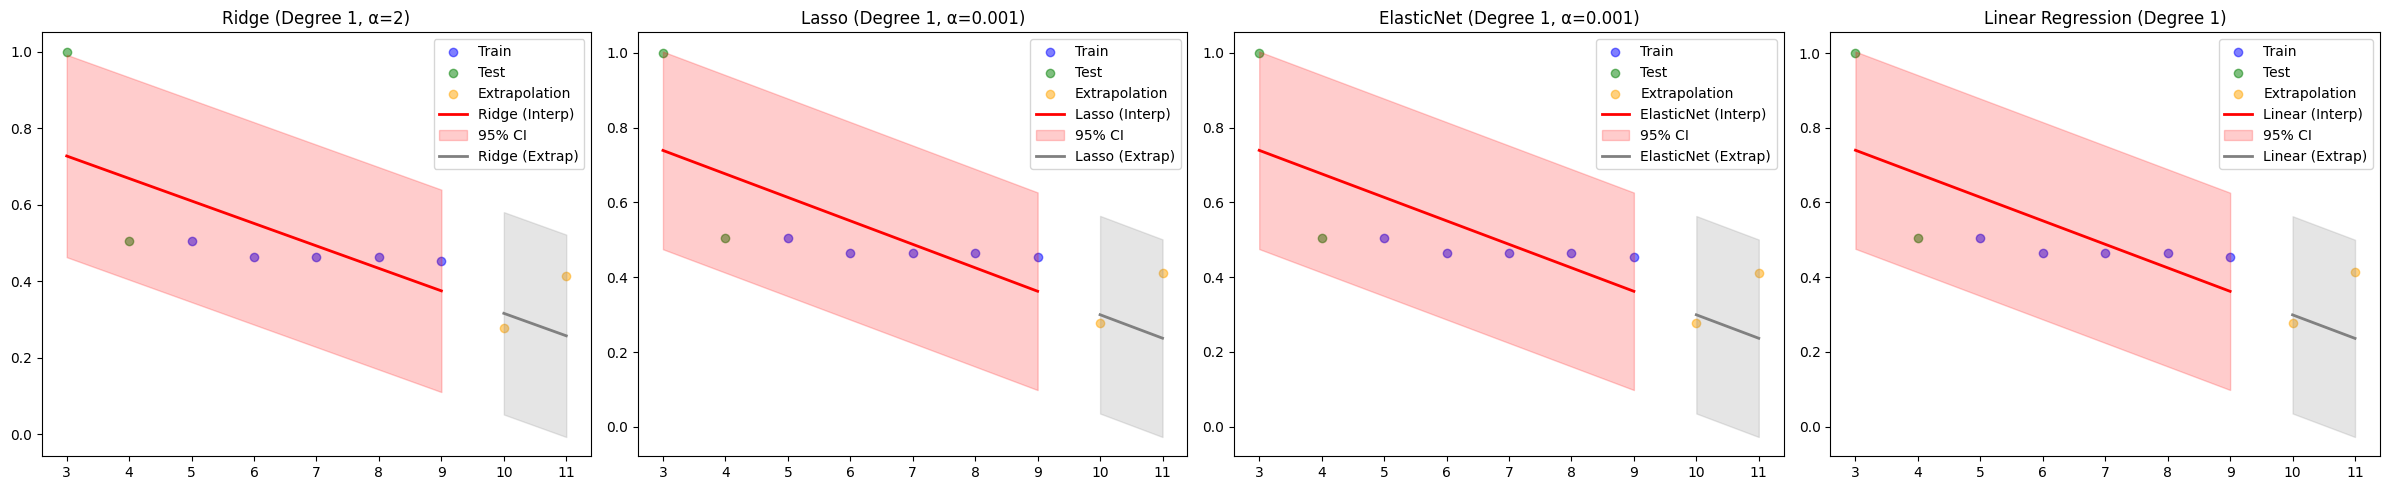

Degree 1:
  Ridge (α=2, MSE=0.0004), ΔR² train & test=-15.5396
  Lasso (α=0.001, MSE=0.0004), ΔR² train & test=-17.5461
  ElasticNet (α=0.001, MSE=0.0004), ΔR² train & test=-17.6100
  Linear Regression (MSE=0.0004), ΔR² train & test=-17.6828



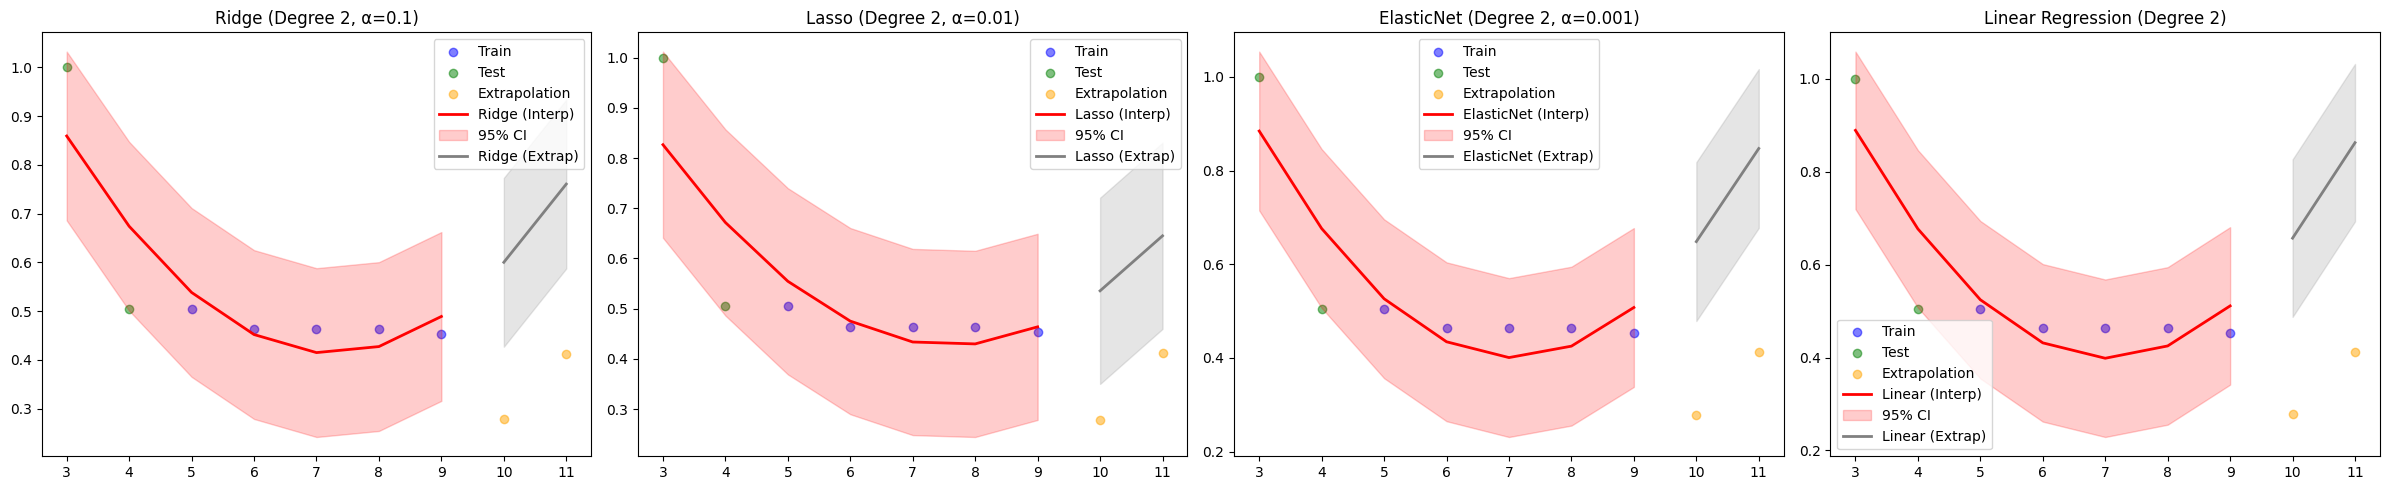

Degree 2:
  Ridge (α=0.1, MSE=0.0004), ΔR² train & test=-3.4602
  Lasso (α=0.01, MSE=0.0004), ΔR² train & test=-2.4653
  ElasticNet (α=0.001, MSE=0.0004), ΔR² train & test=-5.6680
  Linear Regression (MSE=0.0009), ΔR² train & test=-6.1791



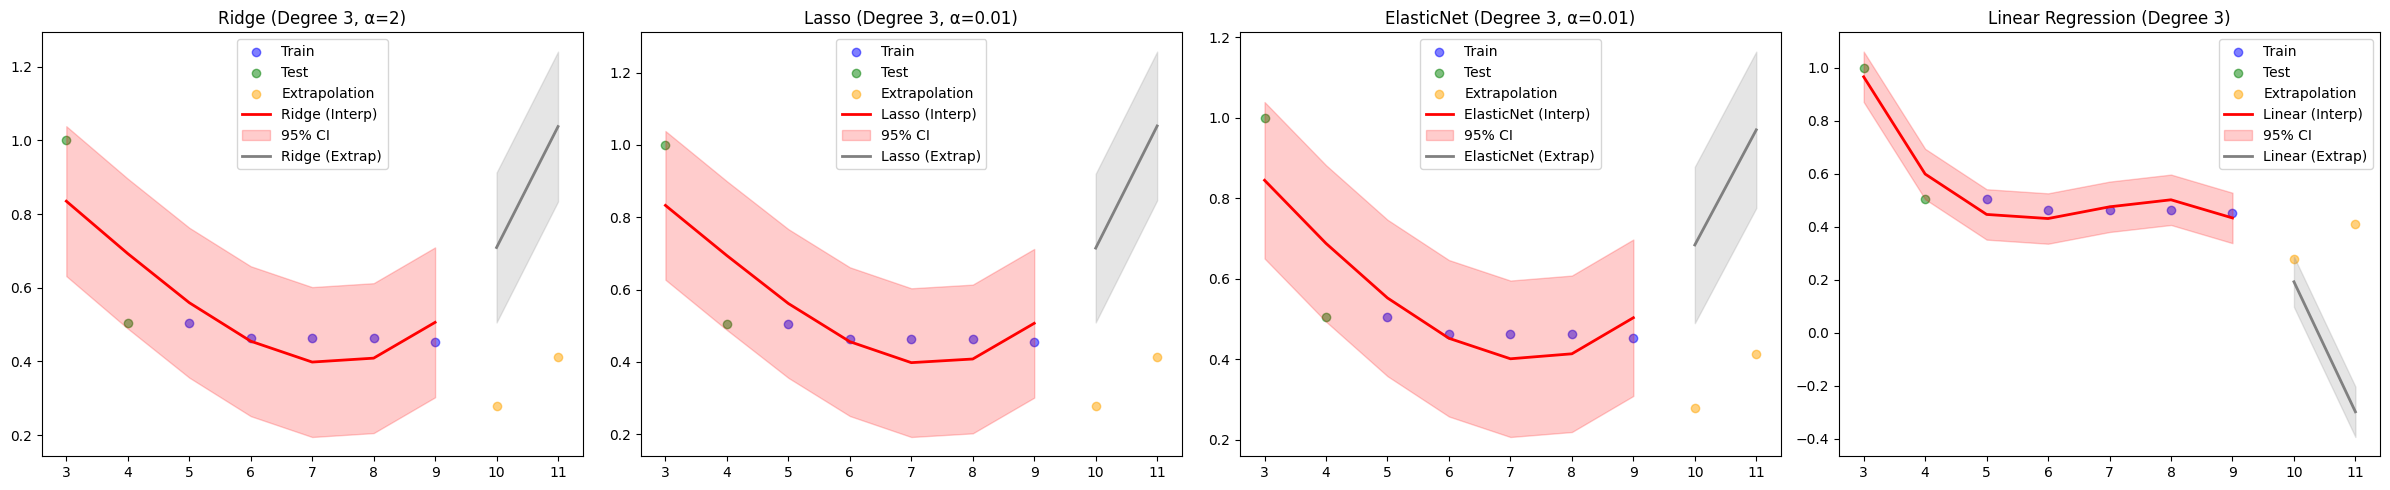

Degree 3:
  Ridge (α=2, MSE=0.0007), ΔR² train & test=-7.6211
  Lasso (α=0.01, MSE=0.0004), ΔR² train & test=-7.8763
  ElasticNet (α=0.01, MSE=0.0005), ΔR² train & test=-6.5077
  Linear Regression (MSE=0.0004), ΔR² train & test=-3.9010



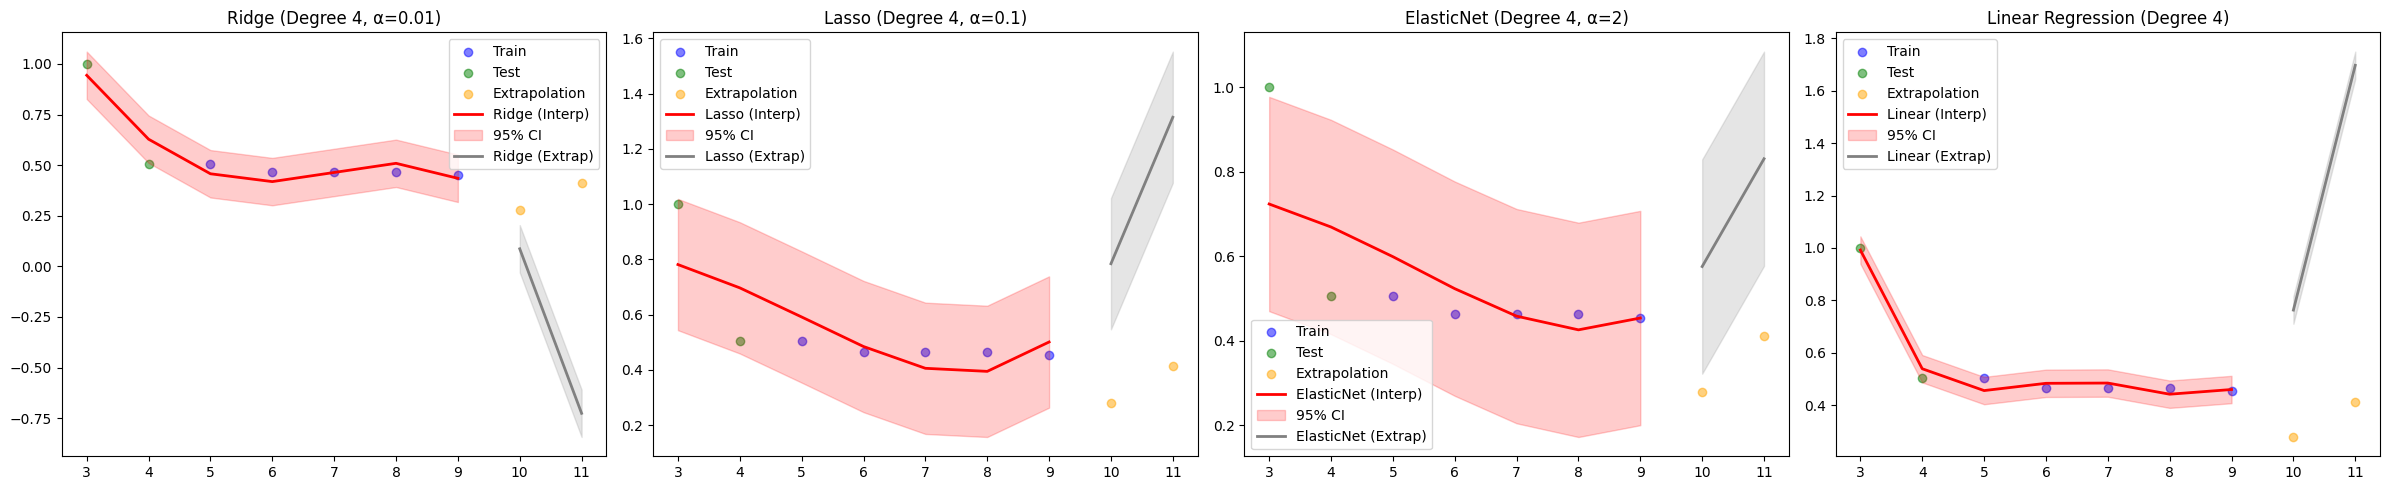

Degree 4:
  Ridge (α=0.01, MSE=0.0004), ΔR² train & test=-4.0109
  Lasso (α=0.1, MSE=0.0005), ΔR² train & test=-10.6444
  ElasticNet (α=2, MSE=0.0005), ΔR² train & test=-7.7575
  Linear Regression (MSE=0.0009), ΔR² train & test=-2.3270



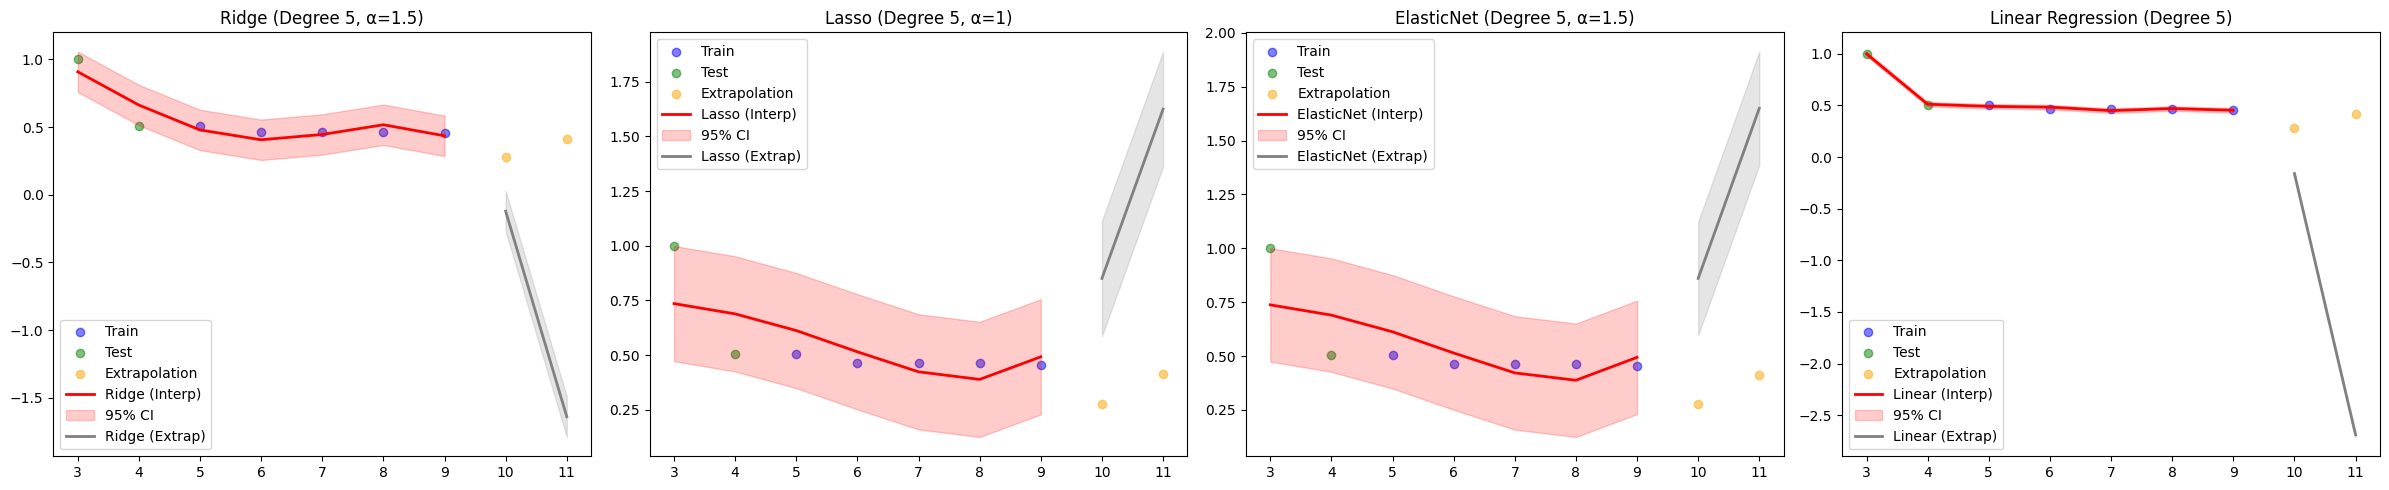

Degree 5:
  Ridge (α=1.5, MSE=0.0004), ΔR² train & test=-4.3794
  Lasso (α=1, MSE=0.0005), ΔR² train & test=-13.2657
  ElasticNet (α=1.5, MSE=0.0005), ΔR² train & test=-13.5408
  Linear Regression (MSE=0.0019), ΔR² train & test=-0.5171



Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('elasticnet', ElasticNet(alpha=1.5, max_iter=10000))])

In [69]:
evaluate_polynomial_regression(df_2020_02,'Month_Num','Retention_Rate')
evaluate_regression_models(df_2020_02,'Month_Num','Retention_Rate')

In [70]:
evaluate_polynomial_regression(df_2020_02,'Month_Num','Retention_Rate', extrap)
evaluate_regression_models(df_2020_02,'Month_Num','Retention_Rate')

NameError: name 'extrap' is not defined